In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import SimpleRNN, Input, Dense
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss

C:\Users\ajpi3\AppData\Local\Temp\ipykernel_18100\1750067656.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Parte 1: Con dataset ORIGINAL (With outliers).

In [2]:
dataset_or = pd.read_csv('data.csv')
dataset_or= dataset_or.drop(columns=['Unnamed: 0'])
dataset_or['consumo'] = pd.to_numeric(dataset_or['consumo'], errors='coerce') #Paso consumo de object a float
dataset_or['muestras_promedio'] = pd.to_numeric(dataset_or['muestras_promedio'], errors='coerce') #Paso muestras_promedio de object a int
dataset_or['subestacion'] = pd.to_numeric(dataset_or['subestacion'], errors='coerce') #Paso barra de object a int

#ordenar la lista en caso que se encuentre desordenado
dataset_or = dataset_or.sort_values('horario')
dataset_or

horario     consumo  flag  muestras_promedio   año  \
0        2017-02-28 18:00:00+00:00  -28.206767     1                  4  2017   
22       2017-02-28 18:00:00+00:00  116.025003     0                  1  2017   
23       2017-02-28 18:00:00+00:00  120.118144     1                  4  2017   
24       2017-02-28 18:00:00+00:00  -32.904251     1                  4  2017   
25       2017-02-28 18:00:00+00:00   32.913292     1                  4  2017   
...                            ...         ...   ...                ...   ...   
2242943  2023-06-28 03:00:00+00:00  181.509562     1                  4  2023   
2242944  2023-06-28 03:00:00+00:00   -0.230716     1                  4  2023   
2242945  2023-06-28 03:00:00+00:00 -264.172966     1                  4  2023   
2242947  2023-06-28 03:00:00+00:00  137.404750     1                  4  2023   
2242967  2023-06-28 03:00:00+00:00   -0.113527     1                  4  2023   

         mes  dia  hora    barra  subestacion Interruptores  
0          2   28    18  AJAHUEL          110            H1  
22         2   28    18  AJAHUEL          110            H5  
23         2   28    18  AJAHUEL          110            H6  
24         2   28    18   CNAVIA          110            H4  
25         2   28    18   CNAVIA          110            H3  
...      ...  ...   ...      ...          ...           ...  
2242943    6   28     3  ELSALTO          110            H1  
2242944    6   28     3     BUIN          110            H3  
2242945    6   28     3    CHENA          110           HT1  
2242947    6   28     3   CNAVIA          110            H8  
2242967    6   28     3     BUIN          110            H4  

[2242968 rows x 11 columns]

In [3]:
dataset_or = dataset_or.groupby(['horario', 'barra']).agg({
    'consumo': 'sum',
    'año': 'first',
    'mes': 'first',
    'dia': 'first',
    'hora': 'first'
}).reset_index()

In [4]:
dataset_or

horario    barra     consumo   año  mes  dia  hora
0       2017-02-28 18:00:00+00:00  AJAHUEL  179.705306  2017    2   28    18
1       2017-02-28 18:00:00+00:00     BUIN   -1.194389  2017    2   28    18
2       2017-02-28 18:00:00+00:00    CHENA  241.126675  2017    2   28    18
3       2017-02-28 18:00:00+00:00   CNAVIA  395.884138  2017    2   28    18
4       2017-02-28 18:00:00+00:00  ELSALTO  586.911362  2017    2   28    18
...                           ...      ...         ...   ...  ...  ...   ...
387116  2023-06-28 03:00:00+00:00    CHENA  266.818674  2023    6   28     3
387117  2023-06-28 03:00:00+00:00   CNAVIA  425.395149  2023    6   28     3
387118  2023-06-28 03:00:00+00:00  ELSALTO  477.814554  2023    6   28     3
387119  2023-06-28 03:00:00+00:00  FLORIDA  -11.979165  2023    6   28     3
387120  2023-06-28 03:00:00+00:00  LOSALME  182.670918  2023    6   28     3

[387121 rows x 7 columns]

### Transpaso a dummys para dataset original (con outliers incluido) para mlp y rnn.

In [5]:
#dataset_dum_or = dataset original con dummys 

barra_dummy = pd.get_dummies(dataset_or['barra'], prefix = "barra")
dataset_dum_or = pd.concat([dataset_or , barra_dummy], axis = 1)


# Vamos a cambiar los true/false a 1/0
columnas_booleanas = dataset_dum_or.select_dtypes(include=bool).columns


# True = 1, False = 0
for dato_booleano in columnas_booleanas:
    dataset_dum_or[dato_booleano] = dataset_dum_or[dato_booleano].astype(int)



columnas = list(dataset_dum_or.columns)
columnas_barra_dummy = [col for col in columnas if col.startswith('barra_')] #Buscando columna x columna variables dummy ciudad.
columnas_no_dummy = [col for col in columnas if (col not in columnas_barra_dummy) ] # Si no es variable dummy, se guarda en este array.
columnas_no_dummy = ['barra','horario','año','mes','dia','hora','consumo']
dataset_dum_or = dataset_dum_or[columnas_barra_dummy  + columnas_no_dummy] # mismo dataset pero  ordenado por dummy ciudad -> dummy interruptores -> no dummy.
dataset_dum_or

dataset_dum_or

barra_AJAHUEL  barra_BUIN  barra_CHENA  barra_CNAVIA  barra_ELSALTO  \
0                   1           0            0             0              0   
1                   0           1            0             0              0   
2                   0           0            1             0              0   
3                   0           0            0             1              0   
4                   0           0            0             0              1   
...               ...         ...          ...           ...            ...   
387116              0           0            1             0              0   
387117              0           0            0             1              0   
387118              0           0            0             0              1   
387119              0           0            0             0              0   
387120              0           0            0             0              0   

        barra_FLORIDA  barra_LOSALME    barra                    horario  \
0                   0              0  AJAHUEL  2017-02-28 18:00:00+00:00   
1                   0              0     BUIN  2017-02-28 18:00:00+00:00   
2                   0              0    CHENA  2017-02-28 18:00:00+00:00   
3                   0              0   CNAVIA  2017-02-28 18:00:00+00:00   
4                   0              0  ELSALTO  2017-02-28 18:00:00+00:00   
...               ...            ...      ...                        ...   
387116              0              0    CHENA  2023-06-28 03:00:00+00:00   
387117              0              0   CNAVIA  2023-06-28 03:00:00+00:00   
387118              0              0  ELSALTO  2023-06-28 03:00:00+00:00   
387119              1              0  FLORIDA  2023-06-28 03:00:00+00:00   
387120              0              1  LOSALME  2023-06-28 03:00:00+00:00   

         año  mes  dia  hora     consumo  
0       2017    2   28    18  179.705306  
1       2017    2   28    18   -1.194389  
2       2017    2   28    18  241.126675  
3       2017    2   28    18  395.884138  
4       2017    2   28    18  586.911362  
...      ...  ...  ...   ...         ...  
387116  2023    6   28     3  266.818674  
387117  2023    6   28     3  425.395149  
387118  2023    6   28     3  477.814554  
387119  2023    6   28     3  -11.979165  
387120  2023    6   28     3  182.670918  

[387121 rows x 14 columns]

In [6]:
dataset_dum_or['horario'] = pd.to_datetime(dataset_dum_or['horario'],utc=True) #pasa el horario a tipo datatime y dejar el utc a 0
dataset_dum_or['consumo'] = pd.to_numeric(dataset_dum_or['consumo'], errors='coerce') #Paso consumo de object a float
dataset_dum_or['año'] = pd.to_numeric(dataset_dum_or['año'], errors='coerce') #Paso consumo de object a int
dataset_dum_or['mes'] = pd.to_numeric(dataset_dum_or['mes'], errors='coerce') #Paso consumo de object a int
dataset_dum_or['dia'] = pd.to_numeric(dataset_dum_or['dia'], errors='coerce') #Paso consumo de object a int
dataset_dum_or['hora'] = pd.to_numeric(dataset_dum_or['hora'], errors='coerce') #Paso consumo de object a int

In [7]:
#separar datos de entrenamiento por años train de 2022 para abajo
#datos de prueba usamos el año 2023
data_train = dataset_dum_or[(dataset_dum_or["año"]>2017) & (dataset_dum_or["año"]<2022)] 
data_test = dataset_dum_or[(dataset_dum_or["año"]==2022)]

In [8]:
barras = dataset_dum_or['barra'].unique()

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    # Divide los datos en entrenamiento y validación en variables de distinta ciudad
    globals()['X_train_mlp_'+barra] = df_train[['año','mes','dia','hora']]
    globals()['X_test_mlp_'+barra] = df_test[['año','mes','dia','hora']]
    globals()['Y1_train_mlp_'+barra] = df_train[['consumo']]
    globals()['Y1_test_mlp_'+barra] = df_test[['consumo']]

## Preparación para MLP

In [9]:
#transforma los datos en una lista nunpy de tipo float32
barras = dataset_dum_or['barra'].unique()
for barra in barras:
    globals()['X_train_mlp_'+barra] = np.asarray(globals()['X_train_mlp_'+barra]).astype('float32')
    globals()['X_test_mlp_'+barra] = np.asarray(globals()['X_test_mlp_'+barra]).astype('float32')
    globals()['Y1_train_mlp_'+barra] = np.asarray(globals()['Y1_train_mlp_'+barra]).astype('float32')
    globals()['Y1_test_mlp_'+barra] = np.asarray(globals()['Y1_test_mlp_'+barra]).astype('float32')

### Ver cual optimizador en el MLP funciona mejor.

In [10]:
batch_size = 64

In [11]:
# Definir el modelo mlp (opción, con perdida de error cuadrado absoluto)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_mlp_AJAHUEL.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])
# Compilar el modelo 
model.compile(optimizer='adam',
              loss='mean_absolute_error',  
              metrics=['mae','mse','mape'])  

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
tag="mlp_or_AJAHUEL"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_AJAHUEL, Y1_train_mlp_AJAHUEL, epochs=20, validation_data=(X_test_mlp_AJAHUEL, Y1_test_mlp_AJAHUEL), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_AJAHUEL, Y1_test_mlp_AJAHUEL)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 44.8018 - mae: 44.8018 - mape: 142331408.0000 - mse: 3118.7310 - val_loss: 74.5257 - val_mae: 74.5257 - val_mape: 36590332.0000 - val_mse: 10142.3672
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - loss: 43.2559 - mae: 43.2559 - mape: 163069488.0000 - mse: 2939.4492 - val_loss: 73.2425 - val_mae: 73.2425 - val_mape: 37057140.0000 - val_mse: 9732.6104
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 42.4972 - mae: 42.4972 - mape: 163693312.0000 - mse: 2866.2266 - val_loss: 80.2877 - val_mae: 80.2877 - val_mape: 30184256.0000 - val_mse: 12035.8154
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - loss: 41.8360 - mae: 41.8360 - mape: 150449168.0000 - mse: 2826.5315 - val_loss: 73.3735 - val_mae: 73.3735 - val_mape: 35030752.0000 - val_mse: 9899.8691
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - loss: 41.4830 - mae: 41.4830 - mape: 164411792.0000 - mse: 2787.7214 - val_loss: 73.4411 - val_mae: 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/model_mlp_or_AJAHUEL20240427-103740.

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


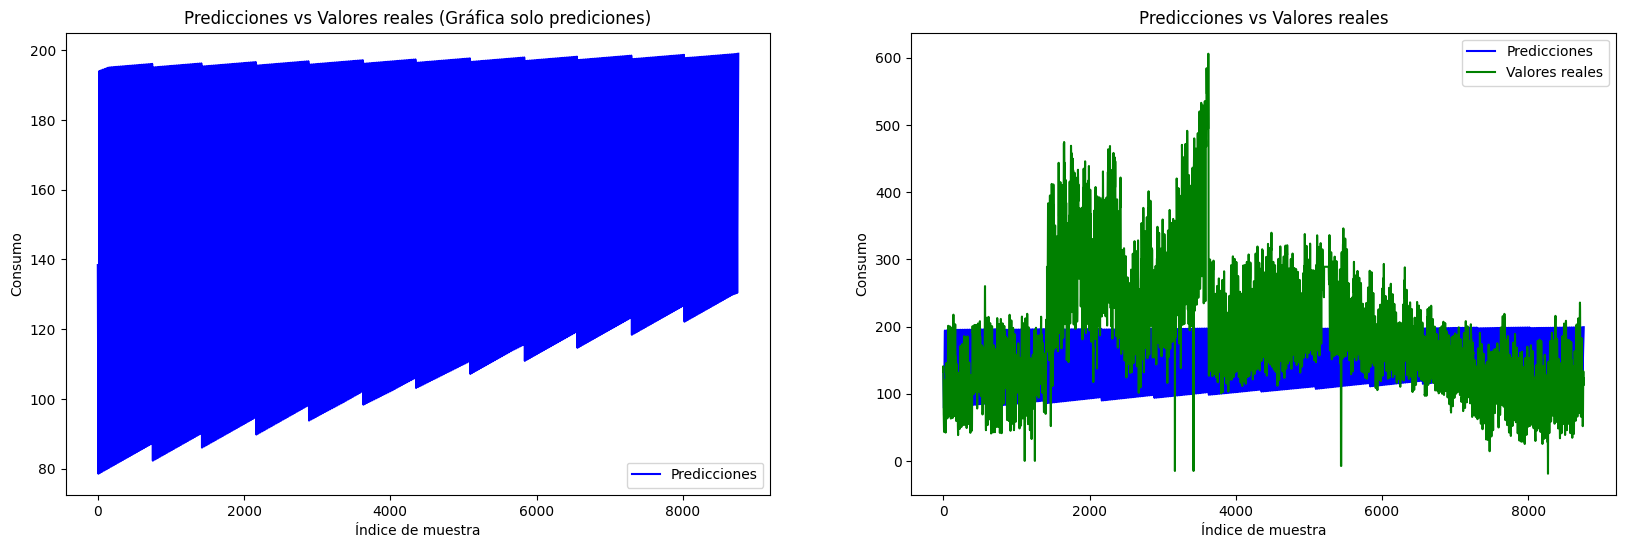

In [ ]:
predicciones = model.predict(X_test_mlp_AJAHUEL)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_AJAHUEL, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_BUIN"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_BUIN, Y1_train_mlp_BUIN, epochs=20, validation_data=(X_test_mlp_BUIN, Y1_test_mlp_BUIN), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_BUIN, Y1_test_mlp_BUIN)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 14.4162 - mae: 14.4162 - mape: 15665431.0000 - mse: 964.1886 - val_loss: 1.1118 - val_mae: 1.1118 - val_mape: 341978.0312 - val_mse: 1.6050
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 1.9010 - mae: 1.9010 - mape: 7500084.0000 - mse: 7.9989 - val_loss: 0.7947 - val_mae: 0.7947 - val_mape: 268792.6562 - val_mse: 0.7280
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.9036 - mae: 0.9036 - mape: 3424897.5000 - mse: 3.3067 - val_loss: 0.7543 - val_mae: 0.7543 - val_mape: 249949.5156 - val_mse: 0.6776
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.7644 - mae: 0.7644 - mape: 3809125.5000 - mse: 2.6170 - val_loss: 1.1865 - val_mae: 1.1865 - val_mape: 36372.8359 - val_mse: 1.8418
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1.0013 - mae: 1.0013 - mape: 4541673.0000 - mse: 7.9849 - val_loss: 0.7818 - val_mae: 0.7818 - val_mape: 236671.0625 - val_mse: 0.7093
Epoch 6/20
546/546 ━━━

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/model_mlp_or_BUIN20240427-015248.

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


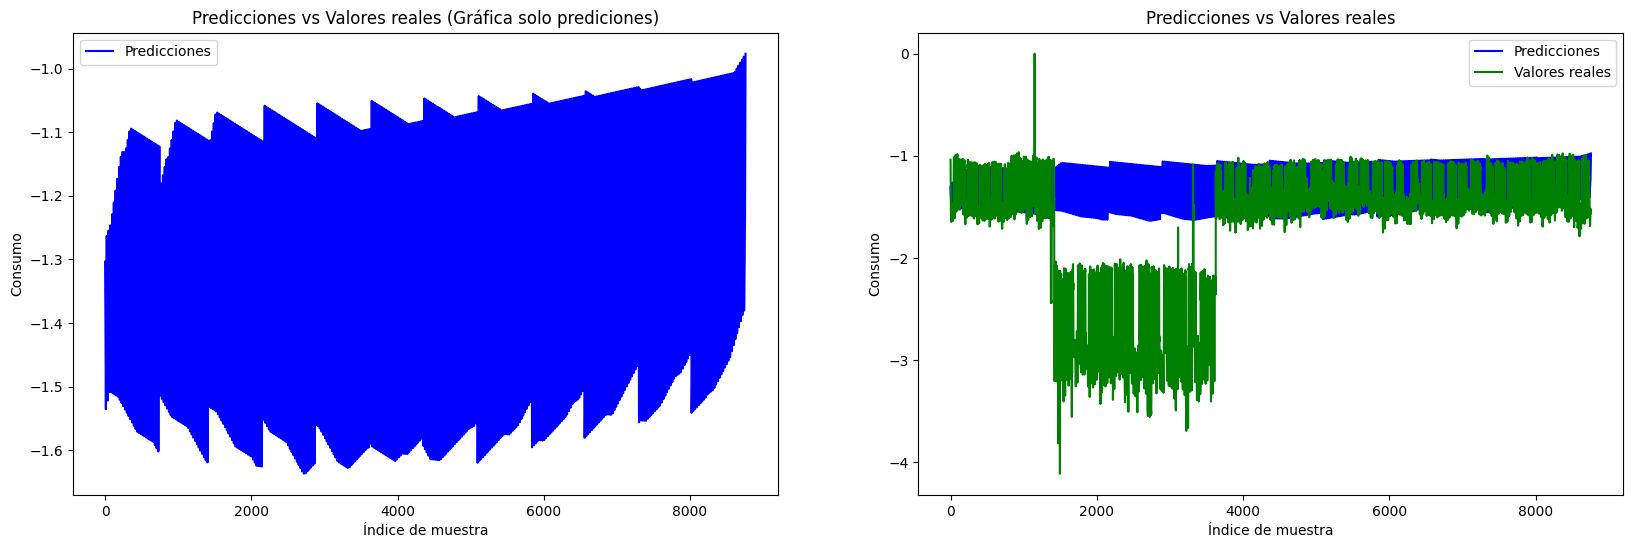

In [ ]:
predicciones = model.predict(X_test_mlp_BUIN)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_BUIN, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_CHENA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_CHENA, Y1_train_mlp_CHENA, epochs=20, validation_data=(X_test_mlp_CHENA, Y1_test_mlp_CHENA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_CHENA, Y1_test_mlp_CHENA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 59.4895 - mae: 59.4895 - mape: 482640704.0000 - mse: 6640.1094 - val_loss: 89.0002 - val_mae: 89.0002 - val_mape: 21860454.0000 - val_mse: 16219.0049
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 38.9397 - mae: 38.9397 - mape: 437543936.0000 - mse: 2276.9382 - val_loss: 82.7361 - val_mae: 82.7361 - val_mape: 24052576.0000 - val_mse: 14269.8799
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 38.4508 - mae: 38.4508 - mape: 515280256.0000 - mse: 2270.5356 - val_loss: 81.0551 - val_mae: 81.0551 - val_mape: 25008454.0000 - val_mse: 13674.0303
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 38.2314 - mae: 38.2314 - mape: 503186624.0000 - mse: 2264.6484 - val_loss: 84.7231 - val_mae: 84.7231 - val_mape: 23690936.0000 - val_mse: 15027.9932
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 38.1593 - mae: 38.1593 - mape: 501949568.0000 - mse: 2249.0691 - val_loss: 81.8102 - val_mae: 81.8102

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/model_mlp_or_CHENA20240427-015308.

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


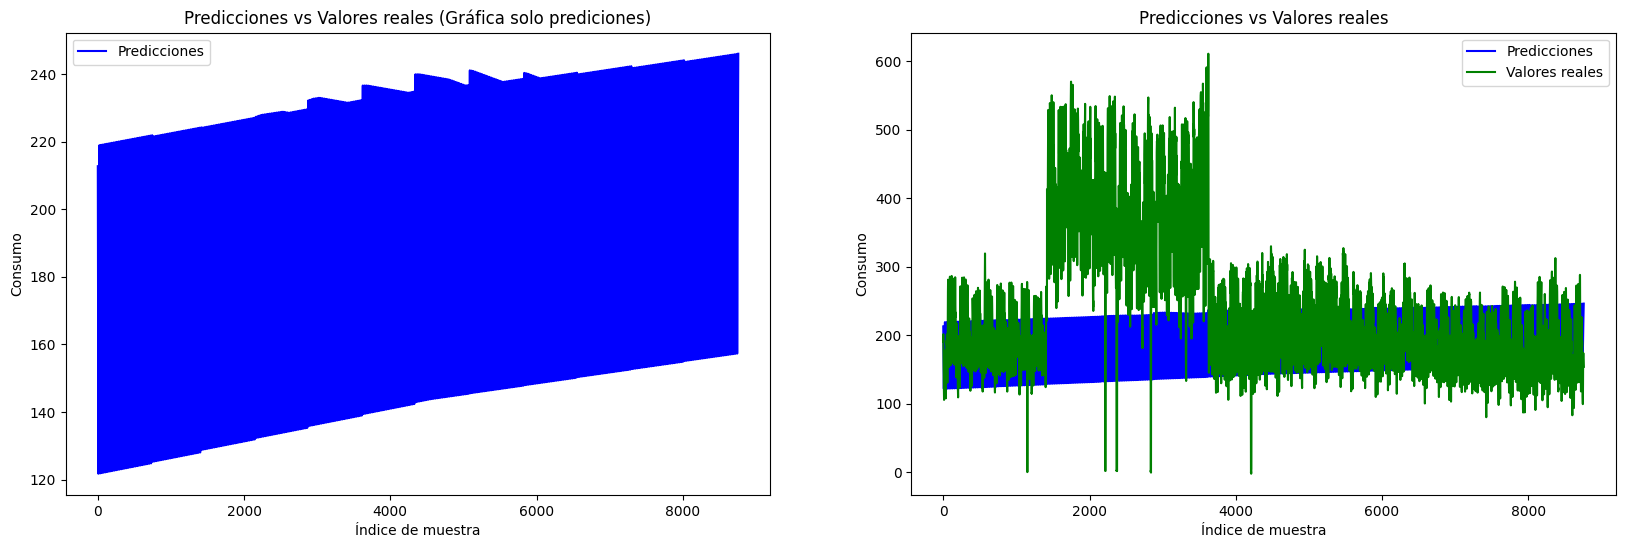

In [ ]:
predicciones = model.predict(X_test_mlp_CHENA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_CHENA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_CNAVIA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_CNAVIA, Y1_train_mlp_CNAVIA, epochs=20, validation_data=(X_test_mlp_CNAVIA, Y1_test_mlp_CNAVIA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_CNAVIA, Y1_test_mlp_CNAVIA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 84.4398 - mae: 84.4398 - mape: 82511816.0000 - mse: 11296.4873 - val_loss: 170.4126 - val_mae: 170.4126 - val_mape: 35.4355 - val_mse: 62803.2578
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 74.3455 - mae: 74.3455 - mape: 154509504.0000 - mse: 8544.1523 - val_loss: 172.5781 - val_mae: 172.5781 - val_mape: 35.7391 - val_mse: 63894.0547
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 74.2590 - mae: 74.2590 - mape: 179639840.0000 - mse: 8479.5947 - val_loss: 170.5505 - val_mae: 170.5505 - val_mape: 35.8710 - val_mse: 62252.7695
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 73.4921 - mae: 73.4921 - mape: 157251776.0000 - mse: 8361.7832 - val_loss: 167.5874 - val_mae: 167.5874 - val_mape: 37.3166 - val_mse: 58544.1953
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 72.9222 - mae: 72.9222 - mape: 131086656.0000 - mse: 8268.1055 - val_loss: 172.1976 - val_mae: 172.1976 - val_mape: 3

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/model_mlp_or_CNAVIA20240427-015327.

274/274 [==============================] - 0s 850us/step


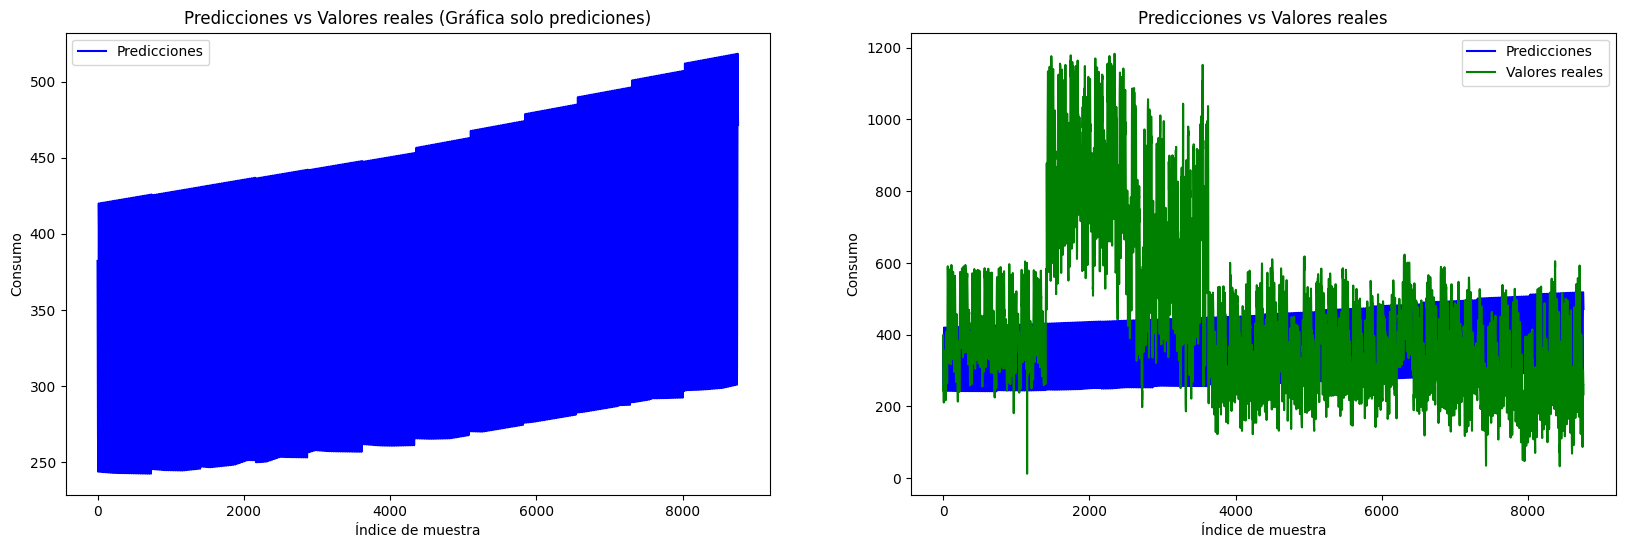

In [ ]:
predicciones = model.predict(X_test_mlp_CNAVIA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_CNAVIA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_ELSALTO"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_ELSALTO, Y1_train_mlp_ELSALTO, epochs=20, validation_data=(X_test_mlp_ELSALTO, Y1_test_mlp_ELSALTO), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_ELSALTO, Y1_test_mlp_ELSALTO)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 81.3123 - mae: 81.3123 - mse: 10743.3477 - mape: 2094123776.0000 - val_loss: 181.8811 - val_mae: 181.8811 - val_mse: 72938.3516 - val_mape: 50537848.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 77.7590 - mae: 77.7590 - mse: 9876.6094 - mape: 2115979264.0000 - val_loss: 175.5785 - val_mae: 175.5785 - val_mse: 68468.7344 - val_mape: 54194644.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 75.8330 - mae: 75.8330 - mse: 9413.2197 - mape: 2123781888.0000 - val_loss: 167.4771 - val_mae: 167.4771 - val_mse: 62682.5781 - val_mape: 56306148.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 74.5319 - mae: 74.5319 - mse: 9119.9531 - mape: 2125454976.0000 - val_loss: 174.4939 - val_mae: 174.4939 - val_mse: 69110.7656 - val_mape: 51543392.0000
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 74.1750 - mae: 74

INFO:tensorflow:Assets written to: models/model_mlp_or_ELSALTO20240425-223127\assets


274/274 [==============================] - 0s 905us/step


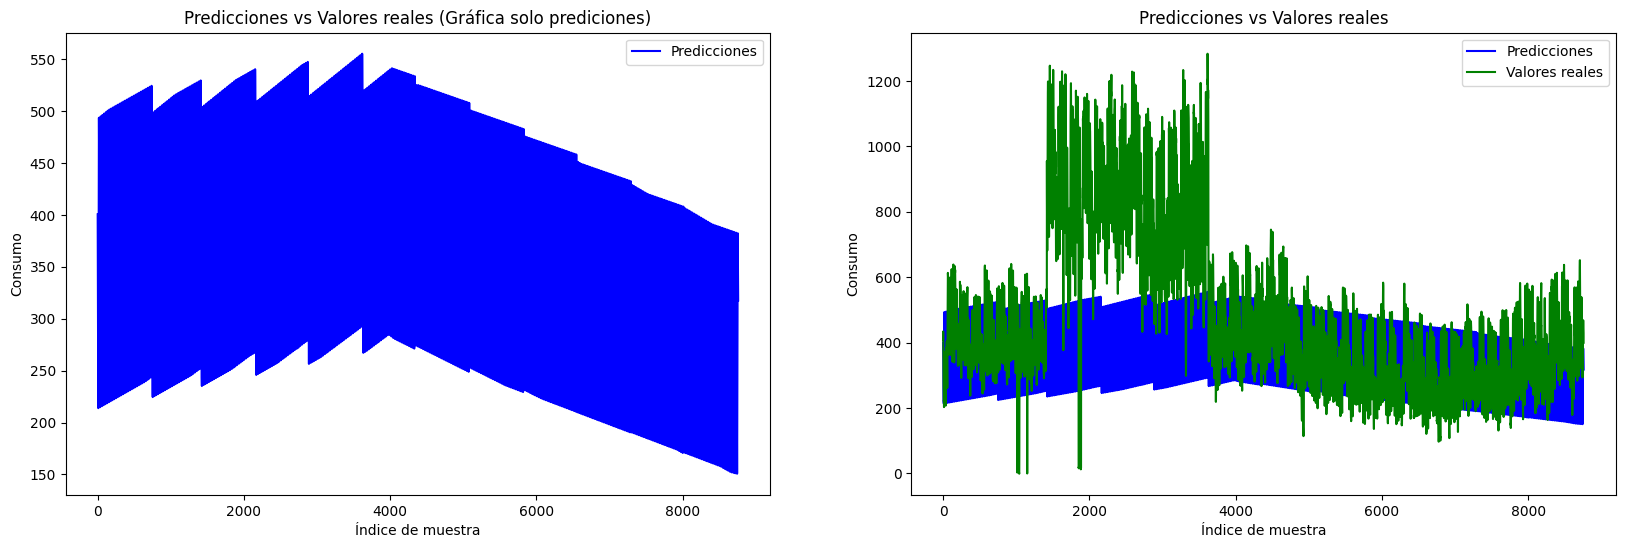

In [ ]:
predicciones = model.predict(X_test_mlp_ELSALTO)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_ELSALTO, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_FLORIDA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_FLORIDA, Y1_train_mlp_FLORIDA, epochs=20, validation_data=(X_test_mlp_FLORIDA, Y1_test_mlp_FLORIDA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_FLORIDA, Y1_test_mlp_FLORIDA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 15.5663 - mae: 15.5663 - mse: 2107.9084 - mape: 1256956.2500 - val_loss: 17.9898 - val_mae: 17.9898 - val_mse: 1118.2603 - val_mape: 205.3533
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 5.6233 - mae: 5.6233 - mse: 124.6766 - mape: 589445.2500 - val_loss: 17.6352 - val_mae: 17.6352 - val_mse: 1093.8636 - val_mape: 208.7403
Epoch 3/20
546/546 [==============================] - 1s 1ms/step - loss: 5.4772 - mae: 5.4772 - mse: 120.6936 - mape: 656403.0000 - val_loss: 17.4847 - val_mae: 17.4847 - val_mse: 1099.6331 - val_mape: 196.8911
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 5.2897 - mae: 5.2897 - mse: 115.7962 - mape: 642676.5625 - val_loss: 16.9340 - val_mae: 16.9340 - val_mse: 1051.3362 - val_mape: 191.0109
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 5.0621 - mae: 5.0621 - mse: 108.1741 - mape: 716776.2500 - val_loss: 17.17

INFO:tensorflow:Assets written to: models/model_mlp_or_FLORIDA20240425-223147\assets


274/274 [==============================] - 0s 905us/step


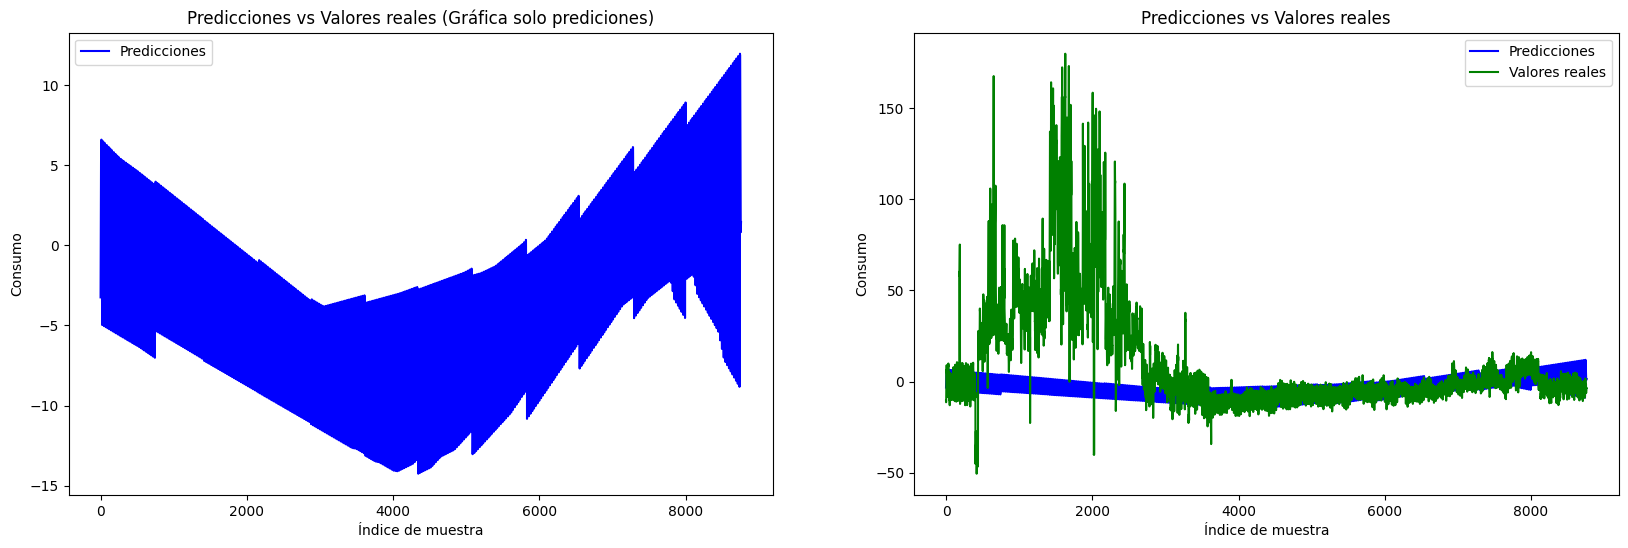

In [ ]:
predicciones = model.predict(X_test_mlp_FLORIDA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_FLORIDA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_or_LOSALME"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_LOSALME, Y1_train_mlp_LOSALME, epochs=20, validation_data=(X_test_mlp_LOSALME, Y1_test_mlp_LOSALME), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_LOSALME, Y1_test_mlp_LOSALME)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 41.4757 - mae: 41.4757 - mse: 2999.7341 - mape: 270202720.0000 - val_loss: 53.6409 - val_mae: 53.6409 - val_mse: 5694.8979 - val_mape: 23424752.0000
Epoch 2/20
546/546 [==============================] - 1s 1ms/step - loss: 35.2934 - mae: 35.2934 - mse: 1952.8076 - mape: 285117600.0000 - val_loss: 53.1723 - val_mae: 53.1723 - val_mse: 5689.5791 - val_mape: 23491980.0000
Epoch 3/20
546/546 [==============================] - 1s 1ms/step - loss: 33.9344 - mae: 33.9344 - mse: 1825.9695 - mape: 286109536.0000 - val_loss: 53.2755 - val_mae: 53.2755 - val_mse: 5831.2773 - val_mape: 23705284.0000
Epoch 4/20
546/546 [==============================] - 1s 1ms/step - loss: 33.2046 - mae: 33.2046 - mse: 1762.6826 - mape: 286575200.0000 - val_loss: 53.2206 - val_mae: 53.2206 - val_mse: 5661.5112 - val_mape: 24577926.0000
Epoch 5/20
546/546 [==============================] - 1s 1ms/step - loss: 32.6998 - mae: 32.6998 - mse: 1721

INFO:tensorflow:Assets written to: models/model_mlp_or_LOSALME20240425-223205\assets


108/274 [==========>...................] - ETA: 0s

274/274 [==============================] - 0s 872us/step


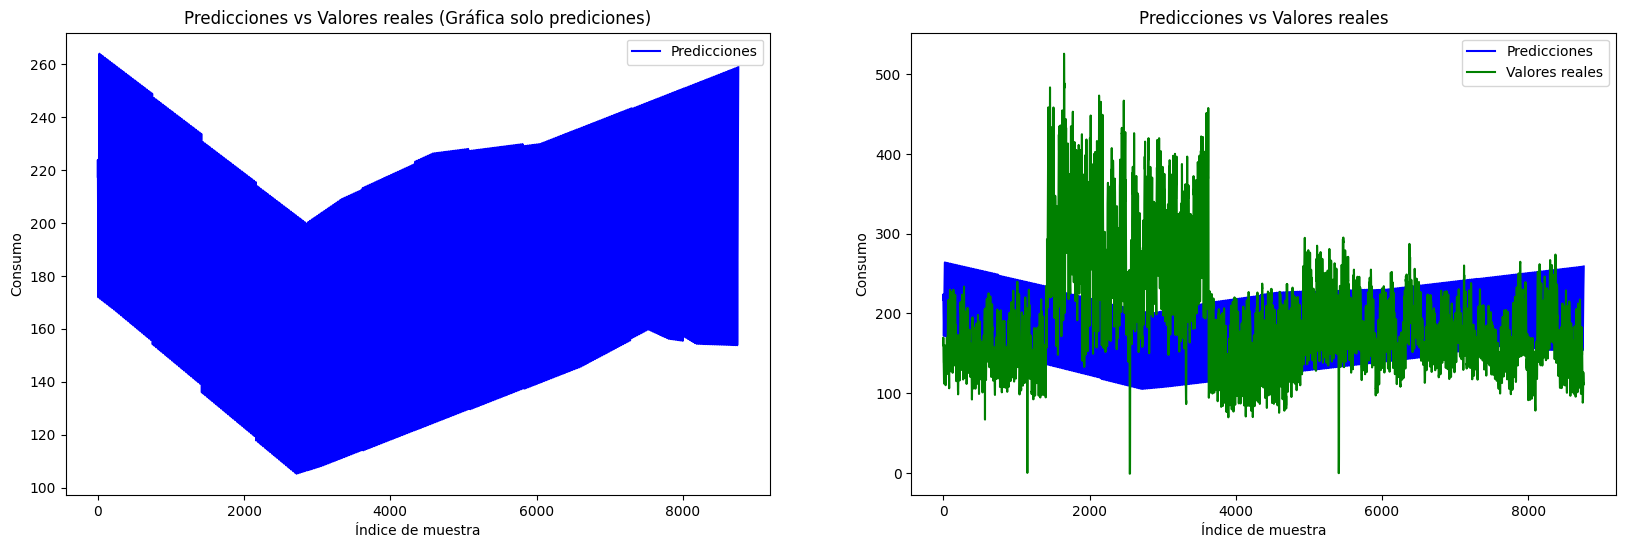

In [ ]:
predicciones = model.predict(X_test_mlp_LOSALME)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_LOSALME, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()


## Preparación para ARIMA

In [15]:
#separar datos de entrenamiento y validacion para arima
barras = dataset_dum_or['barra'].unique() #Se puede usar el dataset de arima.

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación
train_arima_or_dict = {}
test_train_arima_or_dict = {}

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    df_train = pd.concat([df_train, df_test])

    df_train = df_train.set_index('horario')
    df_test = df_test.set_index('horario')

    # Divide los datos en entrenamiento y validación
    train_arima_or_dict[barra] = df_train[['consumo']]
    test_train_arima_or_dict[barra] = df_test[['consumo']]

In [16]:
for barra in dataset_dum_or['barra'].unique():
    print("--------------------------------")
    print("BARRA",barra)
    statistic, p_value, n_lags, critical_values = kpss(train_arima_or_dict[barra].values)
    print(f"Estadístico KPSS: {statistic}\nValor p: {p_value}\nValores críticos: {critical_values}")
    print("La serie es estacionaria.") if p_value < 0.05 else print("La serie no es estacionaria.")
    print("--------------------------------")

--------------------------------
BARRA AJAHUEL
Estadístico KPSS: 2.938176669701572
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA BUIN
Estadístico KPSS: 2.5546466699244013
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA CHENA
Estadístico KPSS: 7.129680832611945
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA CNAVIA
Estadístico KPSS: 6.212401899408551
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA ELSALTO
Estadístico KPSS: 3.5247620942521523
V

C:\Users\ajpi3\AppData\Local\Temp\ipykernel_18100\3960535629.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_arima_or_dict[barra].values)
C:\Users\ajpi3\AppData\Local\Temp\ipykernel_18100\3960535629.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_arima_or_dict[barra].values)
C:\Users\ajpi3\AppData\Local\Temp\ipykernel_18100\3960535629.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_arima_or_dict[barra].values)
C:\Users\ajpi3\AppData\Local\Temp\

In [17]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['AJAHUEL'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_AJAHUEL_fit = model.fit()

# Hacer predicciones para 2023 con AJAHUEL.
prediccion_AJAHUEL = model_AJAHUEL_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['AJAHUEL']
y_pred = prediccion_AJAHUEL

if len(test_train_arima_or_dict['AJAHUEL']) > len(prediccion_AJAHUEL):
    y_true = test_train_arima_or_dict['AJAHUEL'][:len(prediccion_AJAHUEL)]
elif len(test_train_arima_or_dict['AJAHUEL']) < len(prediccion_AJAHUEL):
    y_pred = prediccion_AJAHUEL[:len(test_train_arima_or_dict['AJAHUEL'])]

print("MAE",model_AJAHUEL_fit.mae)
print("MSE",model_AJAHUEL_fit.mse)
print("AIC",model_AJAHUEL_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_AJAHUEL_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 8.31080556591151
MSE 208.87254551337273
AIC 357168.1805215809
mape 96361861556343.34


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -178581.090
Date:                Sat, 27 Apr 2024   AIC                         357168.181
Time:                        10:38:14   BIC                         357194.234
Sample:                             0   HQIC                        357176.393
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5303      0.003    192.761      0.000       0.525       0.536
ma.L1          0.0104      0.002      4.587      0.000       0.006       0.015
sigma2       208.4290      0.265    787.847      0.000     207.911     208.948
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          22963182.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                       115.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

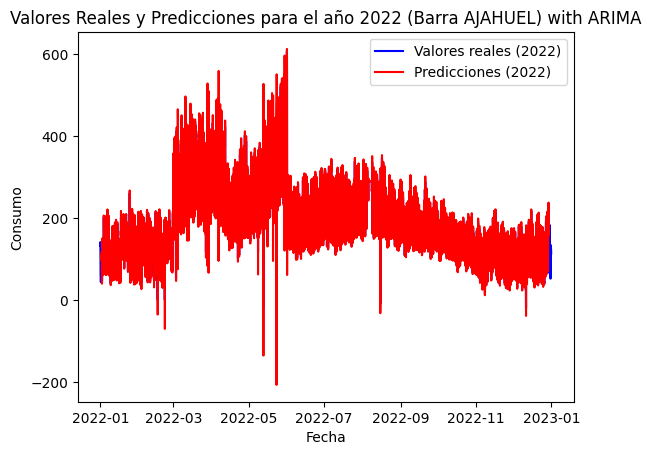

In [20]:
# Hacer predicciones para 2023 con AJAHUEL.
prediccion_AJAHUEL = model_AJAHUEL_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_AJAHUEL = prediccion_AJAHUEL[~prediccion_AJAHUEL.index.duplicated(keep='first')]
prediccion_AJAHUEL = prediccion_AJAHUEL.reindex(test_train_arima_or_dict['AJAHUEL'].index)

plt.plot(test_train_arima_or_dict['AJAHUEL'].index, test_train_arima_or_dict['AJAHUEL']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['AJAHUEL'].index, prediccion_AJAHUEL, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra AJAHUEL) with ARIMA')
plt.legend()

In [30]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['BUIN'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_BUIN_fit = model.fit()

# Hacer predicciones para 2023 con BUIN.
prediccion_BUIN = model_BUIN_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['BUIN']
y_pred = prediccion_BUIN

if len(test_train_arima_or_dict['BUIN']) > len(prediccion_BUIN):
    y_true = test_train_arima_or_dict['BUIN'][:len(prediccion_BUIN)]
elif len(test_train_arima_or_dict['BUIN']) < len(prediccion_BUIN):
    y_pred = prediccion_BUIN[:len(test_train_arima_or_dict['BUIN'])]

print("MAE",model_BUIN_fit.mae)
print("MSE",model_BUIN_fit.mse)
print("AIC",model_BUIN_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_BUIN_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

MAE 0.11106657372352198
MSE 1.5690193730856743
AIC 143630.5687315037
mape 576530042755.4576


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -71812.284
Date:                Sat, 27 Apr 2024   AIC                         143630.569
Time:                        10:55:42   BIC                         143656.622
Sample:                             0   HQIC                        143638.782
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6577      0.000   2188.092      0.000       0.657       0.658
ma.L1         -0.9979      0.000  -4833.150      0.000      -0.998      -0.997
sigma2         1.5690      0.000   1.17e+04      0.000       1.569       1.569
===================================================================================
Ljung-Box (L1) (Q):                 667.28   Jarque-Bera (JB):      607431207802.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                           -67.22
Prob(H) (two-sided):                  0.00   Kurtosis:                     18272.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

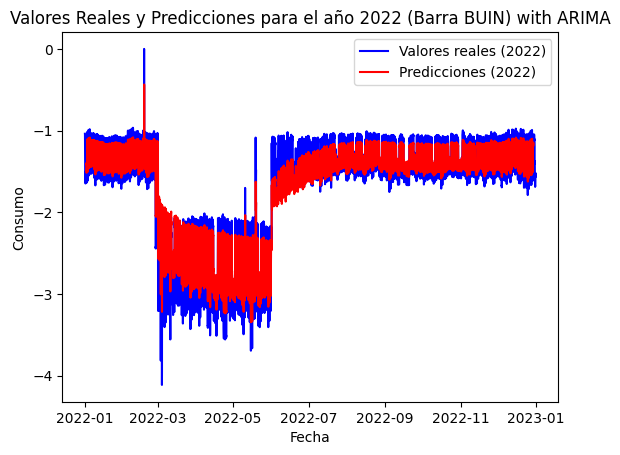

In [31]:
# Hacer predicciones para 2023 con BUIN.
prediccion_BUIN = model_BUIN_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_BUIN = prediccion_BUIN[~prediccion_BUIN.index.duplicated(keep='first')]
prediccion_BUIN = prediccion_BUIN.reindex(test_train_arima_or_dict['BUIN'].index)

plt.plot(test_train_arima_or_dict['BUIN'].index, test_train_arima_or_dict['BUIN']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['BUIN'].index, prediccion_BUIN, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra BUIN) with ARIMA')
plt.legend()

In [23]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['CHENA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_CHENA_fit = model.fit()

# Hacer predicciones para 2023 con CHENA.
prediccion_CHENA = model_CHENA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['CHENA']
y_pred = prediccion_CHENA

if len(test_train_arima_or_dict['CHENA']) > len(prediccion_CHENA):
    y_true = test_train_arima_or_dict['CHENA'][:len(prediccion_CHENA)]
elif len(test_train_arima_or_dict['CHENA']) < len(prediccion_CHENA):
    y_pred = prediccion_CHENA[:len(test_train_arima_or_dict['CHENA'])]

print("MAE",model_CHENA_fit.mae)
print("MSE",model_CHENA_fit.mse)
print("AIC",model_CHENA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_CHENA_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 8.612872117551614
MSE 252.6910514107488
AIC 365453.9844477476
mape 133802704468614.17


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -182723.992
Date:                Sat, 27 Apr 2024   AIC                         365453.984
Time:                        10:43:30   BIC                         365480.038
Sample:                             0   HQIC                        365462.197
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5485      0.004    146.712      0.000       0.541       0.556
ma.L1         -0.1214      0.003    -35.657      0.000      -0.128      -0.115
sigma2       251.9493      0.286    881.104      0.000     251.389     252.510
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):          23132270.91
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                       115.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

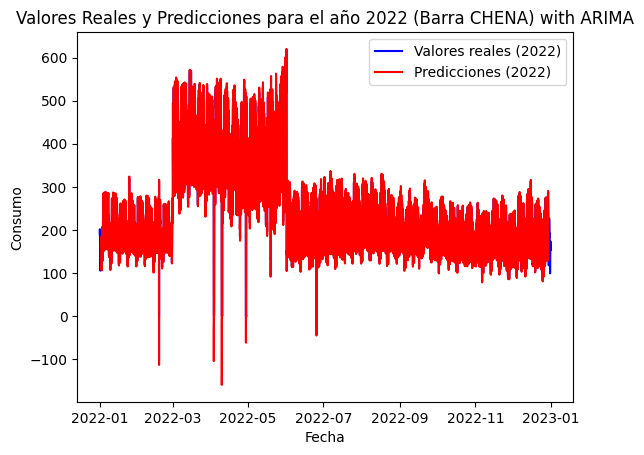

In [25]:
# Hacer predicciones para 2023 con CHENA.
prediccion_CHENA = model_CHENA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_CHENA = prediccion_CHENA[~prediccion_CHENA.index.duplicated(keep='first')]
prediccion_CHENA = prediccion_CHENA.reindex(test_train_arima_or_dict['CHENA'].index)

plt.plot(test_train_arima_or_dict['CHENA'].index, test_train_arima_or_dict['CHENA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['CHENA'].index, prediccion_CHENA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra CHENA) with ARIMA')
plt.legend()

In [26]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['CNAVIA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_CNAVIA_fit = model.fit()

# Hacer predicciones para 2023 con CNAVIA.
prediccion_CNAVIA = model_CNAVIA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['CNAVIA']
y_pred = prediccion_CNAVIA

if len(test_train_arima_or_dict['CNAVIA']) > len(prediccion_CNAVIA):
    y_true = test_train_arima_or_dict['CNAVIA'][:len(prediccion_CNAVIA)]
elif len(test_train_arima_or_dict['CNAVIA']) < len(prediccion_CNAVIA):
    y_pred = prediccion_CNAVIA[:len(test_train_arima_or_dict['CNAVIA'])]

print("MAE",model_CNAVIA_fit.mae)
print("MSE",model_CNAVIA_fit.mse)
print("AIC",model_CNAVIA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_CNAVIA_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 19.122630174875386
MSE 1003.6770766618824
AIC 425698.6492081627
mape 0.06305007671872853


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -212846.325
Date:                Sat, 27 Apr 2024   AIC                         425698.649
Time:                        10:49:06   BIC                         425724.703
Sample:                             0   HQIC                        425706.862
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5415      0.005    114.796      0.000       0.532       0.551
ma.L1         -0.1093      0.004    -25.544      0.000      -0.118      -0.101
sigma2      1000.9173      1.539    650.249      0.000     997.900    1003.934
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):           8014114.06
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Hacer predicciones para 2022 con CNAVIA.
prediccion_CNAVIA = model_CNAVIA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_CNAVIA = prediccion_CNAVIA[~prediccion_CNAVIA.index.duplicated(keep='first')]
prediccion_CNAVIA = prediccion_CNAVIA.reindex(test_train_arima_or_dict['CNAVIA'].index)

plt.plot(test_train_arima_or_dict['CNAVIA'].index, test_train_arima_or_dict['CNAVIA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['CNAVIA'].index, prediccion_CNAVIA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra CNAVIA) with ARIMA')
plt.legend()

In [28]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['ELSALTO'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_ELSALTO_fit = model.fit()

# Hacer predicciones para 2022 con ELSALTO.
prediccion_ELSALTO = model_ELSALTO_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['ELSALTO']
y_pred = prediccion_ELSALTO

if len(test_train_arima_or_dict['ELSALTO']) > len(prediccion_ELSALTO):
    y_true = test_train_arima_or_dict['ELSALTO'][:len(prediccion_ELSALTO)]
elif len(test_train_arima_or_dict['ELSALTO']) < len(prediccion_ELSALTO):
    y_pred = prediccion_ELSALTO[:len(test_train_arima_or_dict['ELSALTO'])]

print("MAE",model_ELSALTO_fit.mae)
print("MSE",model_ELSALTO_fit.mse)
print("AIC",model_ELSALTO_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_ELSALTO_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 17.54472937275069
MSE 979.7530138569809
AIC 424714.6714744745
mape 290750397811518.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -212354.336
Date:                Sat, 27 Apr 2024   AIC                         424714.671
Time:                        10:53:50   BIC                         424740.725
Sample:                             0   HQIC                        424722.884
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6512      0.004    162.469      0.000       0.643       0.659
ma.L1         -0.2125      0.004    -54.652      0.000      -0.220      -0.205
sigma2       978.6629      0.958   1022.099      0.000     976.786     980.540
===================================================================================
Ljung-Box (L1) (Q):                   4.33   Jarque-Bera (JB):          32694744.02
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                       136.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

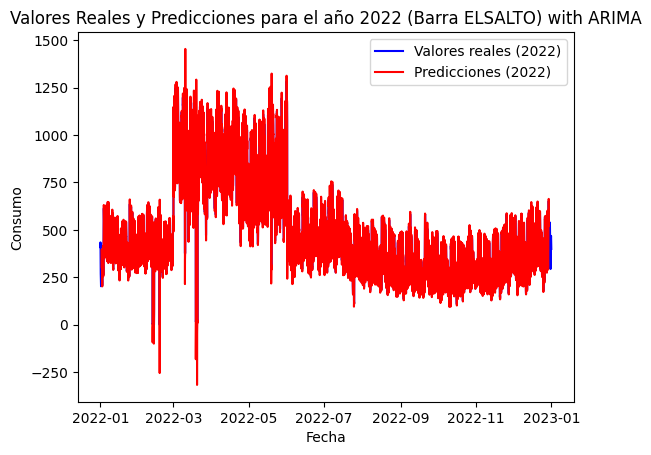

In [29]:
# Hacer predicciones para 2022 con ELSALTO.
prediccion_ELSALTO = model_ELSALTO_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_ELSALTO = prediccion_ELSALTO[~prediccion_ELSALTO.index.duplicated(keep='first')]
prediccion_ELSALTO = prediccion_ELSALTO.reindex(test_train_arima_or_dict['ELSALTO'].index)

plt.plot(test_train_arima_or_dict['ELSALTO'].index, test_train_arima_or_dict['ELSALTO']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['ELSALTO'].index, prediccion_ELSALTO, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra ELSALTO) with ARIMA')
plt.legend()

In [32]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['FLORIDA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_FLORIDA_fit = model.fit()

# Hacer predicciones para 2022 con FLORIDA.
prediccion_FLORIDA = model_FLORIDA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['FLORIDA']
y_pred = prediccion_FLORIDA

if len(test_train_arima_or_dict['FLORIDA']) > len(prediccion_FLORIDA):
    y_true = test_train_arima_or_dict['FLORIDA'][:len(prediccion_FLORIDA)]
elif len(test_train_arima_or_dict['FLORIDA']) < len(prediccion_FLORIDA):
    y_pred = prediccion_FLORIDA[:len(test_train_arima_or_dict['FLORIDA'])]

print("MAE",model_FLORIDA_fit.mae)
print("MSE",model_FLORIDA_fit.mse)
print("AIC",model_FLORIDA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_FLORIDA_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 1.6953630055610456
MSE 22.01202381204552
AIC 258982.35080836996
mape 1.1241991359617987


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -129488.175
Date:                Sat, 27 Apr 2024   AIC                         258982.351
Time:                        10:59:10   BIC                         259008.404
Sample:                             0   HQIC                        258990.564
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3739      0.015    -24.843      0.000      -0.403      -0.344
ma.L1          0.4283      0.015     29.269      0.000       0.400       0.457
sigma2        22.0116      0.017   1292.321      0.000      21.978      22.045
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):          45537301.60
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                       161.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

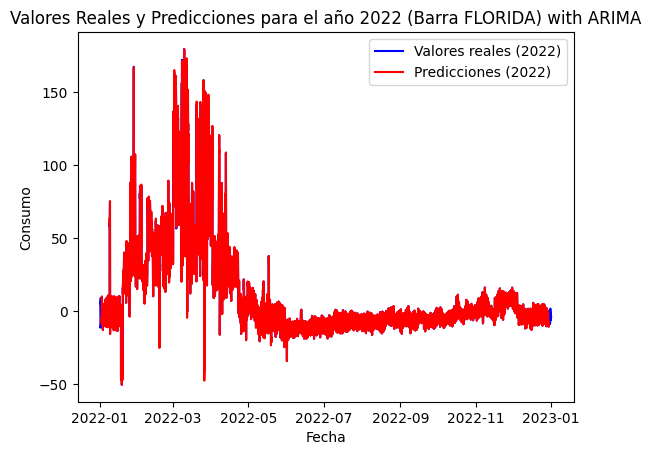

In [35]:
# Hacer predicciones para 2022 con FLORIDA.
prediccion_FLORIDA = model_FLORIDA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_FLORIDA = prediccion_FLORIDA[~prediccion_FLORIDA.index.duplicated(keep='first')]
prediccion_FLORIDA = prediccion_FLORIDA.reindex(test_train_arima_or_dict['FLORIDA'].index)

plt.plot(test_train_arima_or_dict['FLORIDA'].index, test_train_arima_or_dict['FLORIDA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['FLORIDA'].index, prediccion_FLORIDA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra FLORIDA) with ARIMA')
plt.legend()

In [36]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_or_dict['LOSALME'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_LOSALME_fit = model.fit()

# Hacer predicciones para 2022 con LOSALME.
prediccion_LOSALME = model_LOSALME_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_or_dict['LOSALME']
y_pred = prediccion_LOSALME

if len(test_train_arima_or_dict['LOSALME']) > len(prediccion_LOSALME):
    y_true = test_train_arima_or_dict['LOSALME'][:len(prediccion_LOSALME)]
elif len(test_train_arima_or_dict['LOSALME']) < len(prediccion_LOSALME):
    y_pred = prediccion_LOSALME[:len(test_train_arima_or_dict['LOSALME'])]

print("MAE",model_LOSALME_fit.mae)
print("MSE",model_LOSALME_fit.mse)
print("AIC",model_LOSALME_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_LOSALME_fit.summary()

c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajpi3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 8.210784909277896
MSE 200.46075057900393
AIC 355214.7373781807
mape 102749141518002.67


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -177604.369
Date:                Sat, 27 Apr 2024   AIC                         355214.737
Time:                        11:02:11   BIC                         355240.791
Sample:                             0   HQIC                        355222.950
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5298      0.004    126.903      0.000       0.522       0.538
ma.L1         -0.0903      0.004    -24.268      0.000      -0.098      -0.083
sigma2       199.3107      0.262    761.687      0.000     198.798     199.824
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):          23670295.70
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                       116.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Hacer predicciones para 2022 con LOSALME.
prediccion_LOSALME = model_LOSALME_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_LOSALME = prediccion_LOSALME[~prediccion_LOSALME.index.duplicated(keep='first')]
prediccion_LOSALME = prediccion_LOSALME.reindex(test_train_arima_or_dict['LOSALME'].index)

plt.plot(test_train_arima_or_dict['LOSALME'].index, test_train_arima_or_dict['LOSALME']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_or_dict['LOSALME'].index, prediccion_LOSALME, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra LOSALME) with ARIMA')
plt.legend()

## Preparacion con RNN.

In [ ]:
#separar datos de entrenamiento y validacion para RNN
barras = dataset_dum_or['barra'].unique() #Se puede usar el dataset de arima.

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación
train_dict = {}
validation_dict = {}

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    # Divide los datos en entrenamiento y validación
    train_dict[barra] = df_train[['consumo']]
    validation_dict[barra] = df_test[['consumo']]

In [ ]:
#separar datos de entrenamiento y validacion para rnn
# Crea diccionarios para almacenar los resultados
yw_train_dict = {}#X step entrada
yt_train_dict = {}#Y train salida
yw_validation_dict = {}#X step entrada
yt_validation_dict = {}#Y test salida

window_size = 40

# Itera sobre train_dict
for barra, df in train_dict.items():
    y = df['consumo'].values
    yw = []
    yt = []
    for i in range(0, len(y)):
        if i + window_size < len(y):
            row = []
            for j in range(window_size):
                row.append(y[i+j])
            yw.append(row)
            yt.append(y[i+window_size])
        else:
            break
    yw_train_dict[barra] = np.array(yw).astype('float32')
    yt_train_dict[barra] = np.array(yt).astype('float32')

# Itera sobre validation_dict
for barra, df in validation_dict.items():
    y = df['consumo'].values
    yw = []
    yt = []
    for i in range(0, len(y)):
        if i + window_size < len(y):
            row = []
            for j in range(window_size):
                row.append(y[i+j])
            yw.append(row)
            yt.append(y[i+window_size])
        else:
            break
    yw_validation_dict[barra] = np.array(yw).astype('float32')
    yt_validation_dict[barra] = np.array(yt).astype('float32')


In [ ]:
yw_train_dict['AJAHUEL']

array([[137.2935  , 165.37132 , 157.07718 , ..., 133.60846 , 150.23982 ,
        168.96938 ],
       [165.37132 , 157.07718 , 137.33084 , ..., 150.23982 , 168.96938 ,
        180.50427 ],
       [157.07718 , 137.33084 , 124.04555 , ..., 168.96938 , 180.50427 ,
        188.9716  ],
       ...,
       [ 77.70612 ,  67.73743 ,  61.01152 , ..., 160.6023  , 159.8444  ,
        161.966   ],
       [ 67.73743 ,  61.01152 ,  59.988003, ..., 159.8444  , 161.966   ,
        164.34038 ],
       [ 61.01152 ,  59.988003,  62.606255, ..., 161.966   , 164.34038 ,
        157.75342 ]], dtype=float32)

In [ ]:
model = Sequential([
    Input(name="serie", shape=(window_size, 1)),
    SimpleRNN(window_size),
    Dense(1, activation='linear')
])

model.compile(optimizer='Adam', loss='mse', metrics=['mse','mae','mape'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40)                1680      
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1721 (6.72 KB)
Trainable params: 1721 (6.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tag = "rnn_se_or_AJAHUEL" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['AJAHUEL'],
    yt_train_dict['AJAHUEL'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['AJAHUEL'],yt_validation_dict['AJAHUEL']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 8s 6ms/step - loss: 21000.2109 - mse: 21000.2109 - mae: 134.1685 - mape: 12609333.0000 - val_loss: 33104.4492 - val_mse: 33104.4531 - val_mae: 156.3864 - val_mape: 10405963.0000
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 11600.7656 - mse: 11600.7656 - mae: 93.9694 - mape: 38745556.0000 - val_loss: 22583.5332 - val_mse: 22583.5332 - val_mae: 120.7196 - val_mape: 17726430.0000
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 6112.9082 - mse: 6112.9082 - mae: 62.4938 - mape: 58882328.0000 - val_loss: 15662.4014 - val_mse: 15662.4014 - val_mae: 92.4015 - val_mape: 21565518.0000
Epoch 4/36
1163/1163 [==============================] - 8s 6ms/step - loss: 3122.2798 - mse: 3122.2798 - mae: 39.9262 - mape: 65985388.0000 - val_loss: 11166.3154 - val_mse: 11166.3154 - val_mae: 70.9618 - val_mape: 21691044.0000
Epoch 5/36
1163/1163 [==============================] - 11s 9ms/step - lo

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['AJAHUEL'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['AJAHUEL'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

273/273 [==============================] - 1s 3ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['AJAHUEL'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 97135510000000.0
Final MAE:  17.747880935668945
Final MSE:  1421.915771484375
Final mape:  None


In [ ]:
tag = "rnn_se_or_BUIN" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['BUIN'],
    yt_train_dict['BUIN'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['BUIN'],yt_validation_dict['BUIN']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 9s 7ms/step - loss: 20.8232 - mse: 20.8232 - mae: 0.9095 - mape: 4827992.5000 - val_loss: 10.0404 - val_mse: 10.0404 - val_mae: 1.1150 - val_mape: 90839.2266
Epoch 2/36
1163/1163 [==============================] - 8s 7ms/step - loss: 3.6982 - mse: 3.6982 - mae: 0.2826 - mape: 4715416.5000 - val_loss: 32.5547 - val_mse: 32.5547 - val_mae: 2.1647 - val_mape: 97306.9922
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 3.9091 - mse: 3.9091 - mae: 0.2488 - mape: 7435879.0000 - val_loss: 14.7993 - val_mse: 14.7993 - val_mae: 1.2988 - val_mape: 100884.1797
Epoch 4/36
1163/1163 [==============================] - 8s 7ms/step - loss: 3.5052 - mse: 3.5052 - mae: 0.2118 - mape: 6751429.5000 - val_loss: 22.3391 - val_mse: 22.3391 - val_mae: 1.6831 - val_mape: 108637.7109
Epoch 5/36
1163/1163 [==============================] - 8s 7ms/step - loss: 5.1178 - mse: 5.1178 - mae: 0.3780 - mape: 4001502.5000 - val_loss: 1.47

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['BUIN'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['BUIN'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

273/273 [==============================] - 1s 2ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['BUIN'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 623713260000.0
Final MAE:  1.0272787809371948
Final MSE:  5.204549789428711
Final mape:  None


In [ ]:
tag = "rnn_se_or_CHENA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['CHENA'],
    yt_train_dict['CHENA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['CHENA'],yt_validation_dict['CHENA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 758.7975 - mse: 758.7975 - mae: 17.5653 - mape: 230316512.0000 - val_loss: 9773.6289 - val_mse: 9773.6289 - val_mae: 54.9479 - val_mape: 26333720.0000
Epoch 2/36
1163/1163 [==============================] - 6s 5ms/step - loss: 288.6852 - mse: 288.6852 - mae: 9.7296 - mape: 234935840.0000 - val_loss: 8113.1704 - val_mse: 8113.1704 - val_mae: 47.0502 - val_mape: 28288226.0000
Epoch 3/36
1163/1163 [==============================] - 6s 5ms/step - loss: 223.2927 - mse: 223.2927 - mae: 8.2517 - mape: 250695760.0000 - val_loss: 7242.2983 - val_mse: 7242.2983 - val_mae: 43.8375 - val_mape: 28823654.0000
Epoch 4/36
1163/1163 [==============================] - 6s 5ms/step - loss: 198.2766 - mse: 198.2766 - mae: 7.5993 - mape: 255685296.0000 - val_loss: 6637.0430 - val_mse: 6637.0430 - val_mae: 40.9506 - val_mape: 29382976.0000
Epoch 5/36
1163/1163 [==============================] - 6s 5ms/step - loss: 186.1209 - mse: 186

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


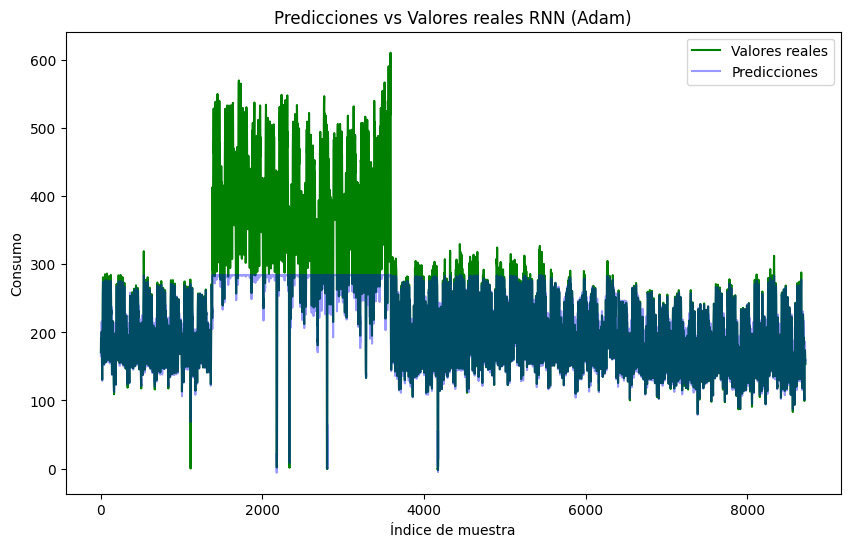

In [ ]:
predicciones = model.predict(yw_validation_dict['CHENA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['CHENA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['CHENA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 129538020000000.0
Final MAE:  36.221317291259766
Final MSE:  5499.35888671875
Final mape:  None


In [ ]:
tag = "rnn_se_or_CNAVIA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['CNAVIA'],
    yt_train_dict['CNAVIA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['CNAVIA'],yt_validation_dict['CNAVIA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 7409.5020 - mse: 7409.5020 - mae: 58.6176 - mape: 59441216.0000 - val_loss: 55831.3281 - val_mse: 55831.3281 - val_mae: 141.0983 - val_mape: 22.0662
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 3830.7925 - mse: 3830.7925 - mae: 40.3182 - mape: 63323820.0000 - val_loss: 47123.8945 - val_mse: 47123.8945 - val_mae: 122.3272 - val_mape: 18.6165
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 2402.0159 - mse: 2402.0159 - mae: 31.4167 - mape: 65010472.0000 - val_loss: 41076.5312 - val_mse: 41076.5312 - val_mae: 110.2861 - val_mape: 16.7946
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1643.1295 - mse: 1643.1295 - mae: 26.0087 - mape: 64059436.0000 - val_loss: 36441.9258 - val_mse: 36441.9258 - val_mae: 101.2580 - val_mape: 15.5703
Epoch 5/36
1163/1163 [==============================] - 6s 5ms/step - loss: 1226.0707 - mse: 1226.07

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


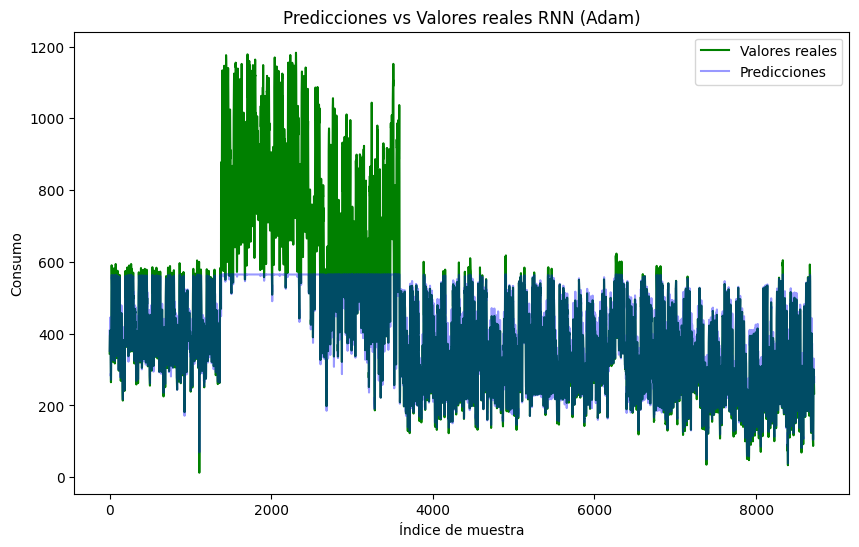

In [ ]:
predicciones = model.predict(yw_validation_dict['CNAVIA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['CNAVIA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['CNAVIA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 0.11720225
Final MAE:  74.43292236328125
Final MSE:  22694.056640625
Final mape:  None


In [ ]:
tag = "rnn_se_or_ELSALTO" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['ELSALTO'],
    yt_train_dict['ELSALTO'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['ELSALTO'],yt_validation_dict['ELSALTO']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 817.9831 - mse: 817.9831 - mae: 17.4857 - mape: 872658880.0000 - val_loss: 30382.5488 - val_mse: 30382.5488 - val_mae: 86.7168 - val_mape: 64497444.0000
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 747.6382 - mse: 747.6381 - mae: 16.8125 - mape: 648356864.0000 - val_loss: 29178.0586 - val_mse: 29178.0586 - val_mae: 85.3254 - val_mape: 63653936.0000
Epoch 3/36
1163/1163 [==============================] - 6s 6ms/step - loss: 734.9039 - mse: 734.9039 - mae: 16.6708 - mape: 590134720.0000 - val_loss: 30762.2891 - val_mse: 30762.2891 - val_mae: 90.2658 - val_mape: 62883192.0000
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 798.2997 - mse: 798.2997 - mae: 17.3854 - mape: 604515008.0000 - val_loss: 29092.8184 - val_mse: 29092.8203 - val_mae: 86.8978 - val_mape: 64060448.0000
Epoch 5/36
1163/1163 [==============================] - 6s 5ms/step - loss: 762.2568

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


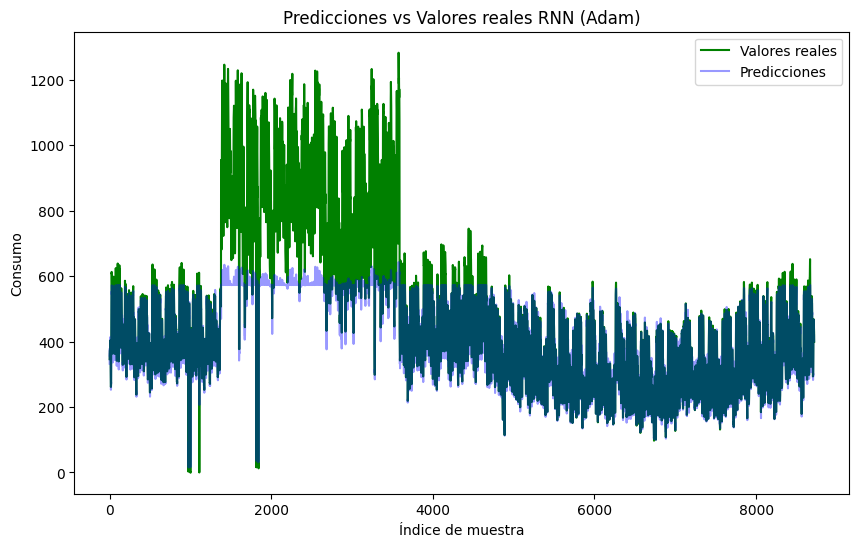

In [ ]:
predicciones = model.predict(yw_validation_dict['ELSALTO'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['ELSALTO'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = print("mape",mean_absolute_percentage_error(yt_validation_dict['ELSALTO'], predicciones))

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 287813580000000.0
Final MAE:  87.69651794433594
Final MSE:  29617.1015625
Final mape:  None


In [ ]:
tag = "rnn_se_or_FLORIDA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['FLORIDA'],
    yt_train_dict['FLORIDA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['FLORIDA'],yt_validation_dict['FLORIDA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 121.3335 - mse: 121.3335 - mae: 5.5139 - mape: 3587729.0000 - val_loss: 92.5375 - val_mse: 92.5375 - val_mae: 5.2626 - val_mape: 281.6393
Epoch 2/36
1163/1163 [==============================] - 6s 6ms/step - loss: 41.1707 - mse: 41.1707 - mae: 3.0517 - mape: 2303131.0000 - val_loss: 80.2272 - val_mse: 80.2272 - val_mae: 4.4805 - val_mape: 180.1169
Epoch 3/36
1163/1163 [==============================] - 6s 5ms/step - loss: 29.9537 - mse: 29.9537 - mae: 2.3890 - mape: 2056119.1250 - val_loss: 86.2787 - val_mse: 86.2787 - val_mae: 4.7562 - val_mape: 175.9055
Epoch 4/36
1163/1163 [==============================] - 6s 6ms/step - loss: 24.7479 - mse: 24.7479 - mae: 2.1715 - mape: 2135640.2500 - val_loss: 74.7167 - val_mse: 74.7167 - val_mae: 4.1809 - val_mape: 156.2930
Epoch 5/36
1163/1163 [==============================] - 6s 6ms/step - loss: 21.7913 - mse: 21.7913 - mae: 2.0110 - mape: 2148469.2500 - val_loss: 96.2

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


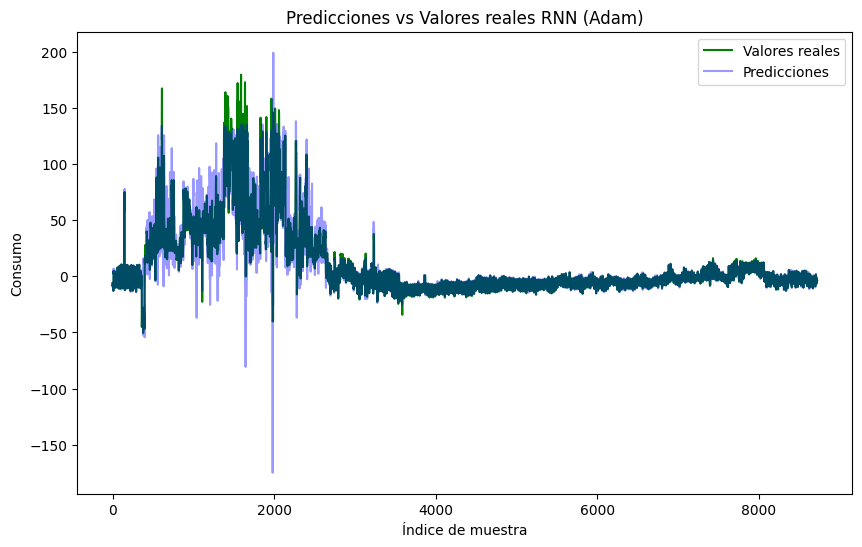

In [ ]:
predicciones = model.predict(yw_validation_dict['FLORIDA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['FLORIDA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = print("mape",mean_absolute_percentage_error(yt_validation_dict['FLORIDA'], predicciones))

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 1.3587607
Final MAE:  4.054068565368652
Final MSE:  92.0399169921875
Final mape:  None


In [ ]:
tag = "rnn_se_or_LOSALME" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_or/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['LOSALME'],
    yt_train_dict['LOSALME'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['LOSALME'],yt_validation_dict['LOSALME']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 6s 6ms/step - loss: 281.7757 - mse: 281.7757 - mae: 10.3632 - mape: 181866368.0000 - val_loss: 1598.3416 - val_mse: 1598.3416 - val_mae: 19.9169 - val_mape: 22572378.0000
Epoch 2/36
1163/1163 [==============================] - 6s 6ms/step - loss: 190.1047 - mse: 190.1047 - mae: 8.7985 - mape: 174904464.0000 - val_loss: 1350.2849 - val_mse: 1350.2849 - val_mae: 18.5000 - val_mape: 22704768.0000
Epoch 3/36
1163/1163 [==============================] - 6s 5ms/step - loss: 169.4627 - mse: 169.4627 - mae: 8.2739 - mape: 172258368.0000 - val_loss: 1189.8083 - val_mse: 1189.8083 - val_mae: 17.1195 - val_mape: 22497474.0000
Epoch 4/36
1163/1163 [==============================] - 6s 6ms/step - loss: 163.0622 - mse: 163.0622 - mae: 8.1120 - mape: 180468768.0000 - val_loss: 1095.7979 - val_mse: 1095.7979 - val_mae: 16.5380 - val_mape: 22506332.0000
Epoch 5/36
1163/1163 [==============================] - 6s 5ms/step - loss: 158.6916 - mse: 158

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['LOSALME'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['LOSALME'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

273/273 [==============================] - 1s 2ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = print("mape",mean_absolute_percentage_error(yt_validation_dict['LOSALME'], predicciones))

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 100463370000000.0
Final MAE:  13.163113594055176
Final MSE:  636.6898803710938
Final mape:  None


## COMPARACION MLP VS ARIMA VS RNN

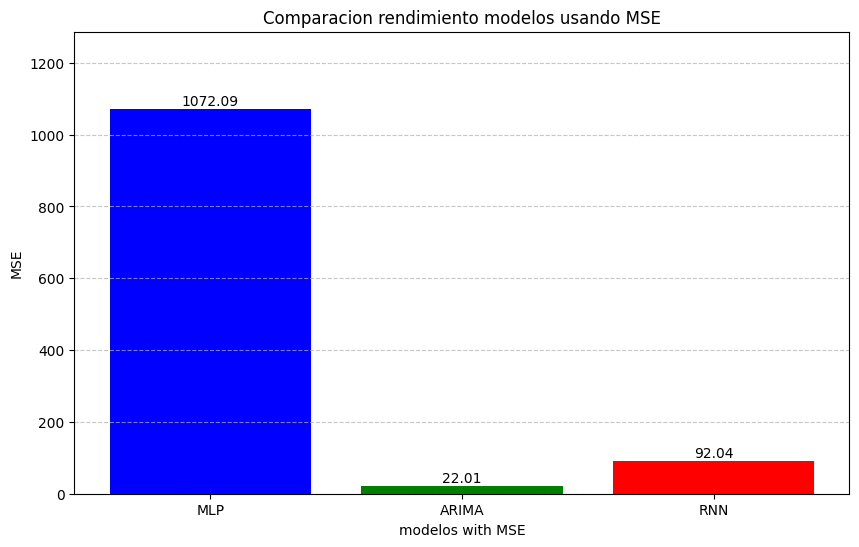

In [ ]:
mse_mlp = 1072.09 # MLPREGRESSOR ES MAS OPTIMIZADO
mse_arima = 22.012
mse_rnn = 92.04

mae_mlp = 16.99 # MLPREGRESSOR ES MAS OPTIMIZADO
mae_arima = 1.69
mae_rnn = 4.05

mape_mlp = 224.03
mape_arima = 1.12
mape_rnn = 1.35

modelos = ['MLP','ARIMA','RNN']

MSE_VALORES = [mse_mlp,mse_arima,mse_rnn]
MAE_VALORES = [mae_mlp,mae_arima,mae_rnn]
MAPE_VALORES = [mape_mlp,mape_arima,mape_rnn]

# GRAFICO COMPARACION MSE:

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MSE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MSE')
plt.ylabel('MSE')
plt.title('Comparacion rendimiento modelos usando MSE')
plt.ylim(0,max(MSE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MSE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()

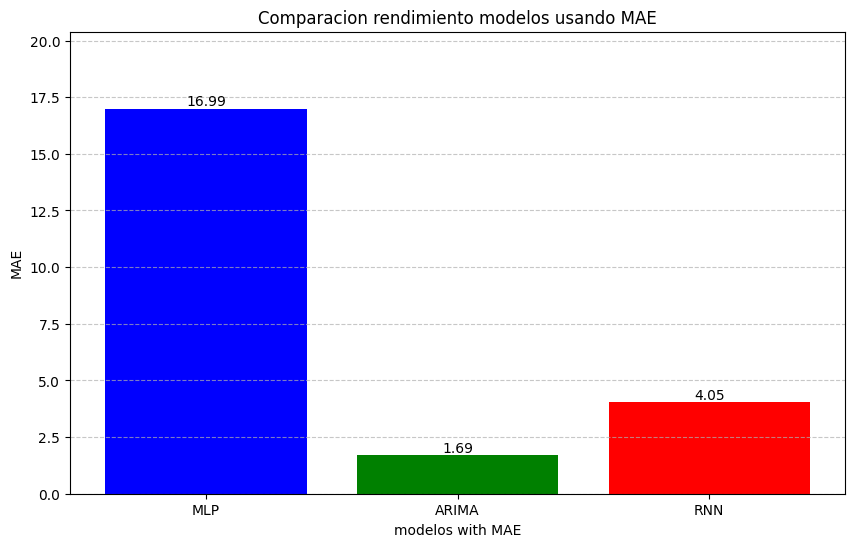

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MAE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MAE')
plt.ylabel('MAE')
plt.title('Comparacion rendimiento modelos usando MAE')
plt.ylim(0,max(MAE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MAE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MAPE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MAPE')
plt.ylabel('MAE')
plt.title('Comparacion rendimiento modelos usando MAPE')
plt.ylim(0,max(MAPE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MAPE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()

### Conclusion: Con dataset original, ARIMA es mas eficiente.

# Parte 2: Con dataset Modificado.

In [ ]:
features = ["barra_AJAHUEL","barra_BUIN","barra_CHENA","barra_CNAVIA","barra_ELSALTO","barra_FLORIDA","barra_LOSALME","barra","horario","año","mes","dia","hora","consumo","flag"]
dataset = pd.read_csv("datatraining.csv",delimiter=',',header=None,names=features)
dataset = dataset.iloc[1:]
dataset['horario'] = pd.to_datetime(dataset['horario'],utc=True) #pasa el horario a tipo datatime y dejar el utc a 0
dataset['consumo'] = pd.to_numeric(dataset['consumo'], errors='coerce') #Paso consumo de object a float
dataset['año'] = pd.to_numeric(dataset['año'], errors='coerce') #Paso consumo de object a int
dataset['mes'] = pd.to_numeric(dataset['mes'], errors='coerce') #Paso consumo de object a int
dataset['dia'] = pd.to_numeric(dataset['dia'], errors='coerce') #Paso consumo de object a int
dataset['hora'] = pd.to_numeric(dataset['hora'], errors='coerce') #Paso consumo de object a int
dataset['flag'] = pd.to_numeric(dataset['flag'], errors='coerce') #Paso barra de object a int

#ordenar la lista en caso que se encuentre desordenado
dataset = dataset.sort_values('horario')

C:\Users\tolli\AppData\Local\Temp\ipykernel_15696\373945200.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("datatraining.csv",delimiter=',',header=None,names=features)


In [ ]:
dataset

barra_AJAHUEL barra_BUIN barra_CHENA barra_CNAVIA barra_ELSALTO  \
0.0                  1          0           0            0             0   
1.0                  0          1           0            0             0   
2.0                  0          0           1            0             0   
3.0                  0          0           0            1             0   
4.0                  0          0           0            0             1   
...                ...        ...         ...          ...           ...   
387114.0             1          0           0            0             0   
387115.0             0          1           0            0             0   
387116.0             0          0           1            0             0   
387117.0             0          0           0            1             0   
387120.0             0          0           0            0             0   

         barra_FLORIDA barra_LOSALME    barra                   horario   año  \
0.0                  0             0  AJAHUEL 2017-02-28 18:00:00+00:00  2017   
1.0                  0             0     BUIN 2017-02-28 18:00:00+00:00  2017   
2.0                  0             0    CHENA 2017-02-28 18:00:00+00:00  2017   
3.0                  0             0   CNAVIA 2017-02-28 18:00:00+00:00  2017   
4.0                  0             0  ELSALTO 2017-02-28 18:00:00+00:00  2017   
...                ...           ...      ...                       ...   ...   
387114.0             0             0  AJAHUEL 2023-06-28 03:00:00+00:00  2023   
387115.0             0             0     BUIN 2023-06-28 03:00:00+00:00  2023   
387116.0             0             0    CHENA 2023-06-28 03:00:00+00:00  2023   
387117.0             0             0   CNAVIA 2023-06-28 03:00:00+00:00  2023   
387120.0             0             1  LOSALME 2023-06-28 03:00:00+00:00  2023   

          mes  dia  hora     consumo  flag  
0.0         2   28    18  179.705306     1  
1.0         2   28    18  279.070591     1  
2.0         2   28    18  521.781588     1  
3.0         2   28    18  395.884138     1  
4.0         2   28    18  586.911362     1  
...       ...  ...   ...         ...   ...  
387114.0    6   28     3  241.198459     1  
387115.0    6   28     3  262.298650     1  
387116.0    6   28     3  407.521219     1  
387117.0    6   28     3  425.395149     1  
387120.0    6   28     3  182.670918     1  

[387121 rows x 15 columns]

In [ ]:
#separar datos de entrenamiento por años train de 2021 para abajo
#datos de prueba usamos el año 2022
data_train = dataset[(dataset["año"]>2017) & (dataset["año"]<2022)] 
data_test = dataset[(dataset["año"]==2022)]

### Preparar MLP

In [ ]:
barras = dataset['barra'].unique()

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    # Divide los datos en entrenamiento y validación en variables de distinta ciudad
    globals()['X_train_mlp_'+barra] = df_train[['año','mes','dia','hora']]
    globals()['X_test_mlp_'+barra] = df_test[['año','mes','dia','hora']]
    globals()['Y1_train_mlp_'+barra] = df_train[['consumo']]
    globals()['Y1_test_mlp_'+barra] = df_test[['consumo']]


In [ ]:
#transforma los datos en una lista nunpy de tipo float32
barras = dataset['barra'].unique()
for barra in barras:
    globals()['X_train_mlp_'+barra] = np.asarray(globals()['X_train_mlp_'+barra]).astype('float32')
    globals()['X_test_mlp_'+barra] = np.asarray(globals()['X_test_mlp_'+barra]).astype('float32')
    globals()['Y1_train_mlp_'+barra] = np.asarray(globals()['Y1_train_mlp_'+barra]).astype('float32')
    globals()['Y1_test_mlp_'+barra] = np.asarray(globals()['Y1_test_mlp_'+barra]).astype('float32')

In [ ]:
batch_size = 64

In [ ]:
# Definir el modelo mlp forma 2 (opción, con perdida de error cuadrado absoluto)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_mlp_AJAHUEL.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])

# Compilar el modelo 
model.compile(optimizer='adam',
              loss='mean_absolute_error',  
              metrics=['mae','mse', 'mape'])  

In [ ]:
tag="mlp_sn_AJAHUEL"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_AJAHUEL, Y1_train_mlp_AJAHUEL, epochs=20, validation_data=(X_test_mlp_AJAHUEL, Y1_test_mlp_AJAHUEL), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_AJAHUEL, Y1_test_mlp_AJAHUEL)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
153/546 [=======>......................] - ETA: 0s - loss: 55.3485 - mae: 55.3485 - mse: 6440.9111 - mape: 134141576.0000

546/546 [==============================] - 2s 2ms/step - loss: 46.5380 - mae: 46.5380 - mse: 3884.4204 - mape: 149153760.0000 - val_loss: 77.8891 - val_mae: 77.8891 - val_mse: 11206.4365 - val_mape: 33693612.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 42.7030 - mae: 42.7030 - mse: 2870.4807 - mape: 147007216.0000 - val_loss: 73.8365 - val_mae: 73.8365 - val_mse: 9977.8936 - val_mape: 36223392.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 42.5317 - mae: 42.5317 - mse: 2871.6790 - mape: 144541376.0000 - val_loss: 74.0510 - val_mae: 74.0510 - val_mse: 10092.1104 - val_mape: 35347148.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 42.1186 - mae: 42.1186 - mse: 2844.0789 - mape: 142013072.0000 - val_loss: 75.5324 - val_mae: 75.5324 - val_mse: 10622.7285 - val_mape: 33469856.0000
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 42.1268 - mae: 42.1268 - mse: 2852.5930 - 

INFO:tensorflow:Assets written to: models/model_mlp_sn_AJAHUEL20240425-233134\assets


 88/274 [========>.....................] - ETA: 0s

274/274 [==============================] - 0s 872us/step


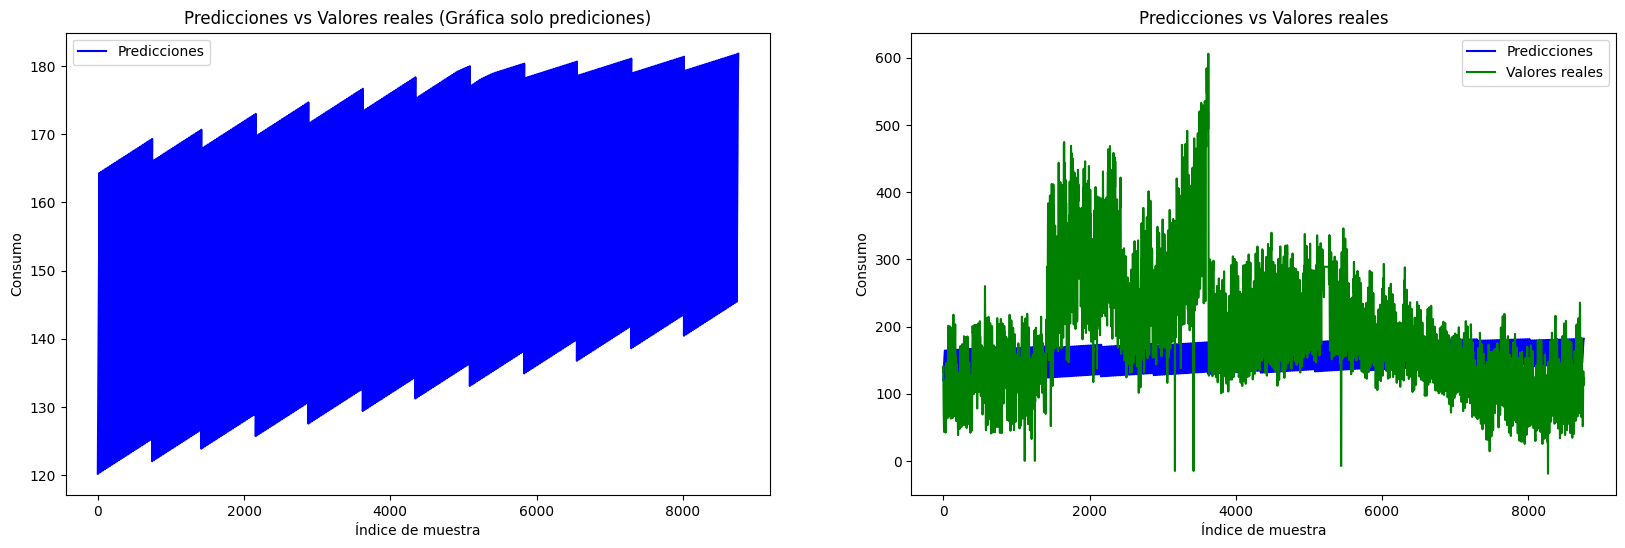

In [ ]:
predicciones = model.predict(X_test_mlp_AJAHUEL)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_AJAHUEL, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
X_train_mlp_BUIN

array([[2.018e+03, 1.000e+00, 1.000e+00, 0.000e+00],
       [2.018e+03, 1.000e+00, 1.000e+00, 1.000e+00],
       [2.018e+03, 1.000e+00, 1.000e+00, 2.000e+00],
       ...,
       [2.021e+03, 1.200e+01, 3.100e+01, 2.100e+01],
       [2.021e+03, 1.200e+01, 3.100e+01, 2.200e+01],
       [2.021e+03, 1.200e+01, 3.100e+01, 2.300e+01]], dtype=float32)

In [ ]:
tag="mlp_sn_BUIN"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_BUIN, Y1_train_mlp_BUIN, epochs=20, validation_data=(X_test_mlp_BUIN, Y1_test_mlp_BUIN), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_BUIN, Y1_test_mlp_BUIN)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
 65/546 [==>...........................] - ETA: 1s - loss: 70.2090 - mae: 70.2090 - mse: 10729.4434 - mape: 651380800.0000

546/546 [==============================] - 1s 2ms/step - loss: 68.3204 - mae: 68.3204 - mse: 10541.4023 - mape: 576605056.0000 - val_loss: 95.3920 - val_mae: 95.3920 - val_mse: 18258.0117 - val_mape: 25337766.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 67.8879 - mae: 67.8879 - mse: 10418.9932 - mape: 574253376.0000 - val_loss: 93.2163 - val_mae: 93.2163 - val_mse: 17746.4082 - val_mape: 27073014.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 67.7818 - mae: 67.7818 - mse: 10369.0303 - mape: 574473152.0000 - val_loss: 97.8317 - val_mae: 97.8317 - val_mse: 18835.4824 - val_mape: 24549076.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 67.7667 - mae: 67.7667 - mse: 10338.5732 - mape: 570697856.0000 - val_loss: 94.7937 - val_mae: 94.7937 - val_mse: 18166.0859 - val_mape: 25924746.0000
Epoch 5/20
546/546 [==============================] - 1s 1ms/step - loss: 67.6689 - mae: 67.6689 - mse: 10305.3

INFO:tensorflow:Assets written to: models/model_mlp_sn_BUIN20240425-233153\assets


 59/274 [=====>........................] - ETA: 0s

274/274 [==============================] - 0s 846us/step


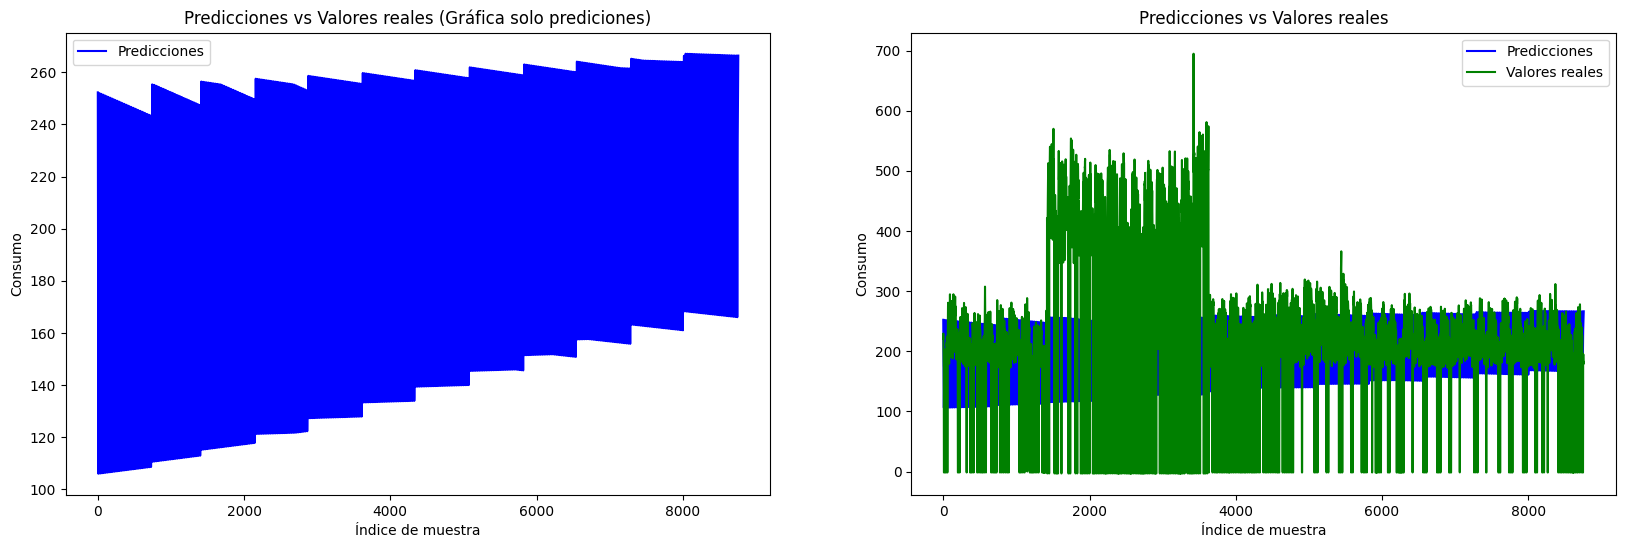

In [ ]:
predicciones = model.predict(X_test_mlp_BUIN)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_BUIN, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_sn_CHENA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_CHENA, Y1_train_mlp_CHENA, epochs=20, validation_data=(X_test_mlp_CHENA, Y1_test_mlp_CHENA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_CHENA, Y1_test_mlp_CHENA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
  1/546 [..............................] - ETA: 3s - loss: 217.3857 - mae: 217.3857 - mse: 52379.3164 - mape: 48.9957

546/546 [==============================] - 1s 2ms/step - loss: 77.1890 - mae: 77.1890 - mse: 11579.6299 - mape: 1051829056.0000 - val_loss: 172.5641 - val_mae: 172.5641 - val_mse: 68225.3750 - val_mape: 54965428.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 74.1641 - mae: 74.1641 - mse: 10627.6875 - mape: 1064760064.0000 - val_loss: 171.7863 - val_mae: 171.7863 - val_mse: 67516.8047 - val_mape: 55860268.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 74.1090 - mae: 74.1090 - mse: 10573.5654 - mape: 1064461312.0000 - val_loss: 170.6960 - val_mae: 170.6960 - val_mse: 66881.9375 - val_mape: 55119308.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 74.1146 - mae: 74.1146 - mse: 10549.3721 - mape: 1064559552.0000 - val_loss: 170.7250 - val_mae: 170.7250 - val_mse: 66900.0781 - val_mape: 55247444.0000
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 73.5284 - mae: 73.5284 - 

INFO:tensorflow:Assets written to: models/model_mlp_sn_CHENA20240425-233213\assets


In [ ]:
predicciones = model.predict(X_test_mlp_CHENA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_CHENA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

274/274 [==============================] - 0s 916us/step


In [ ]:
tag="mlp_sn_CNAVIA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_CNAVIA, Y1_train_mlp_CNAVIA, epochs=20, validation_data=(X_test_mlp_CNAVIA, Y1_test_mlp_CNAVIA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_CNAVIA, Y1_test_mlp_CNAVIA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 70.1198 - mae: 70.1198 - mse: 7546.7231 - mape: 127559648.0000 - val_loss: 187.8265 - val_mae: 187.8265 - val_mse: 78005.2266 - val_mape: 38.0016
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 69.7832 - mae: 69.7832 - mse: 7485.4810 - mape: 128845896.0000 - val_loss: 189.1147 - val_mae: 189.1147 - val_mse: 79975.8203 - val_mape: 37.2056
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 69.6655 - mae: 69.6655 - mse: 7472.3457 - mape: 127961904.0000 - val_loss: 189.7226 - val_mae: 189.7226 - val_mse: 80318.1328 - val_mape: 37.4712
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 69.5239 - mae: 69.5239 - mse: 7468.7314 - mape: 128784080.0000 - val_loss: 191.0637 - val_mae: 191.0637 - val_mse: 80916.9141 - val_mape: 37.9084
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 69.4815 - mae: 69.4815 - mse: 7457.2246 - mape

INFO:tensorflow:Assets written to: models/model_mlp_sn_CNAVIA20240425-233233\assets


274/274 [==============================] - 0s 960us/step


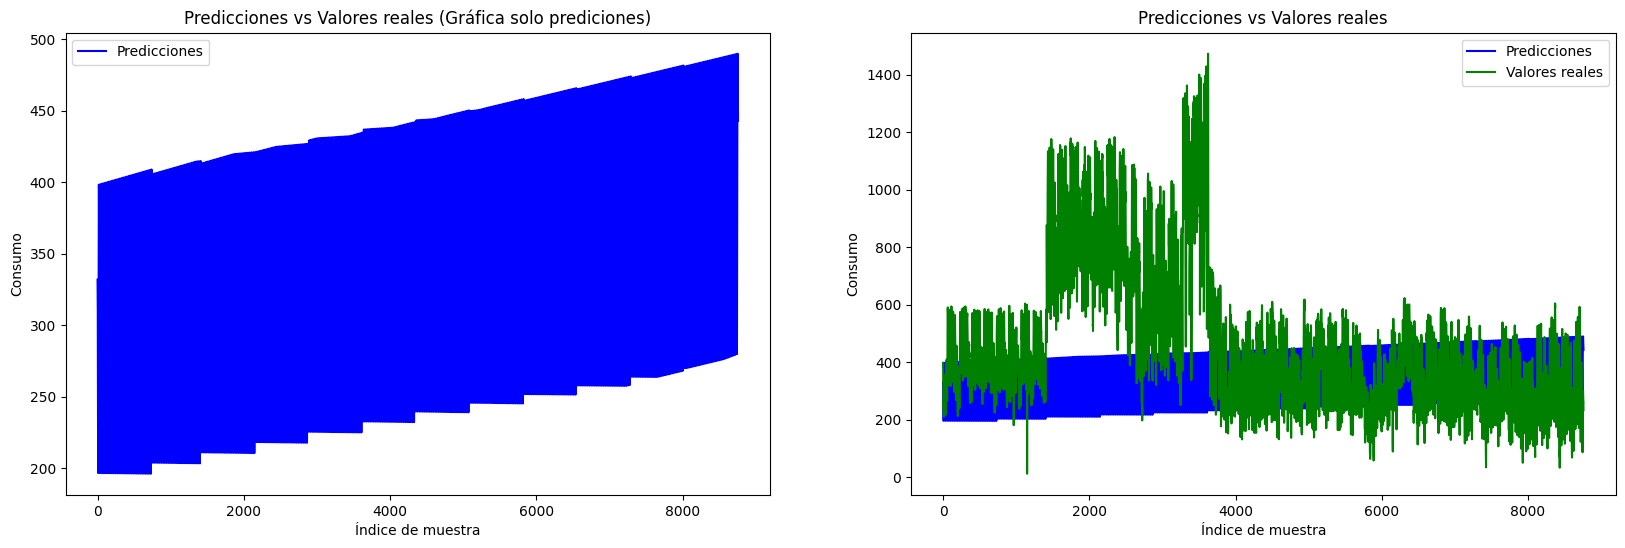

In [ ]:
predicciones = model.predict(X_test_mlp_CNAVIA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_CNAVIA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_sn_ELSALTO"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_ELSALTO, Y1_train_mlp_ELSALTO, epochs=20, validation_data=(X_test_mlp_ELSALTO, Y1_test_mlp_ELSALTO), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_ELSALTO, Y1_test_mlp_ELSALTO)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 77.5867 - mae: 77.5867 - mse: 9804.6523 - mape: 2050940032.0000 - val_loss: 175.7669 - val_mae: 175.7669 - val_mse: 72572.2891 - val_mape: 47894120.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 73.1357 - mae: 73.1357 - mse: 8755.3750 - mape: 2067657216.0000 - val_loss: 162.8630 - val_mae: 162.8630 - val_mse: 62895.7656 - val_mape: 52377984.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 71.7980 - mae: 71.7980 - mse: 8500.7930 - mape: 2085302656.0000 - val_loss: 163.9520 - val_mae: 163.9520 - val_mse: 64250.5625 - val_mape: 52611104.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 71.4306 - mae: 71.4306 - mse: 8437.7510 - mape: 2077153408.0000 - val_loss: 164.3051 - val_mae: 164.3051 - val_mse: 64012.8438 - val_mape: 54389192.0000
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 70.8803 - mae: 70.

INFO:tensorflow:Assets written to: models/model_mlp_sn_ELSALTO20240425-233253\assets


274/274 [==============================] - 0s 802us/step


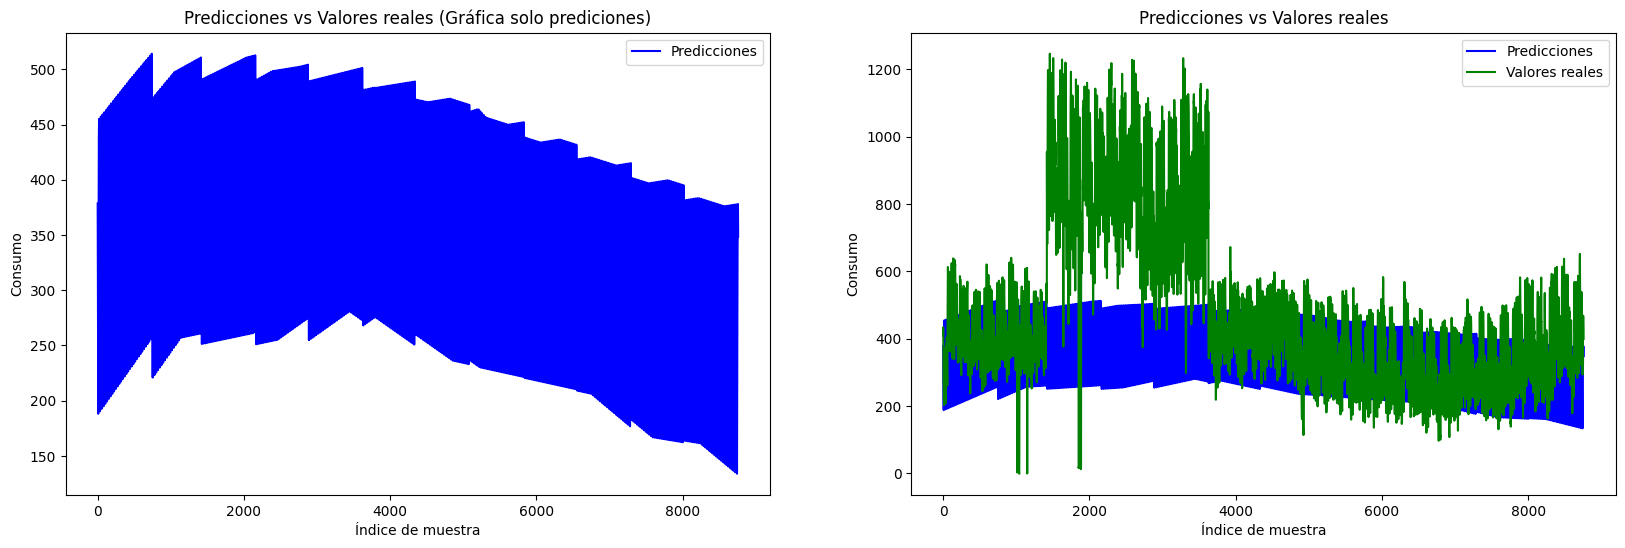

In [ ]:
predicciones = model.predict(X_test_mlp_ELSALTO)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_ELSALTO, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_sn_FLORIDA"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_FLORIDA, Y1_train_mlp_FLORIDA, epochs=20, validation_data=(X_test_mlp_FLORIDA, Y1_test_mlp_FLORIDA), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_FLORIDA, Y1_test_mlp_FLORIDA)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 2ms/step - loss: 17.8121 - mae: 17.8121 - mse: 2424.0950 - mape: 2030812.5000 - val_loss: 18.2844 - val_mae: 18.2844 - val_mse: 1146.5178 - val_mape: 285.5596
Epoch 2/20
546/546 [==============================] - 1s 1ms/step - loss: 5.9571 - mae: 5.9571 - mse: 127.7181 - mape: 486847.5625 - val_loss: 17.6068 - val_mae: 17.6068 - val_mse: 1058.6169 - val_mape: 181.1877
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 5.6129 - mae: 5.6129 - mse: 121.1360 - mape: 500892.0000 - val_loss: 17.4849 - val_mae: 17.4849 - val_mse: 1082.5017 - val_mape: 232.1954
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 5.3381 - mae: 5.3381 - mse: 114.9845 - mape: 332371.9062 - val_loss: 17.4970 - val_mae: 17.4970 - val_mse: 1062.0756 - val_mape: 280.8496
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 5.3252 - mae: 5.3252 - mse: 113.1769 - mape: 586987.3750 - val_loss: 17.89

INFO:tensorflow:Assets written to: models/model_mlp_sn_FLORIDA20240425-233313\assets


274/274 [==============================] - 0s 872us/step


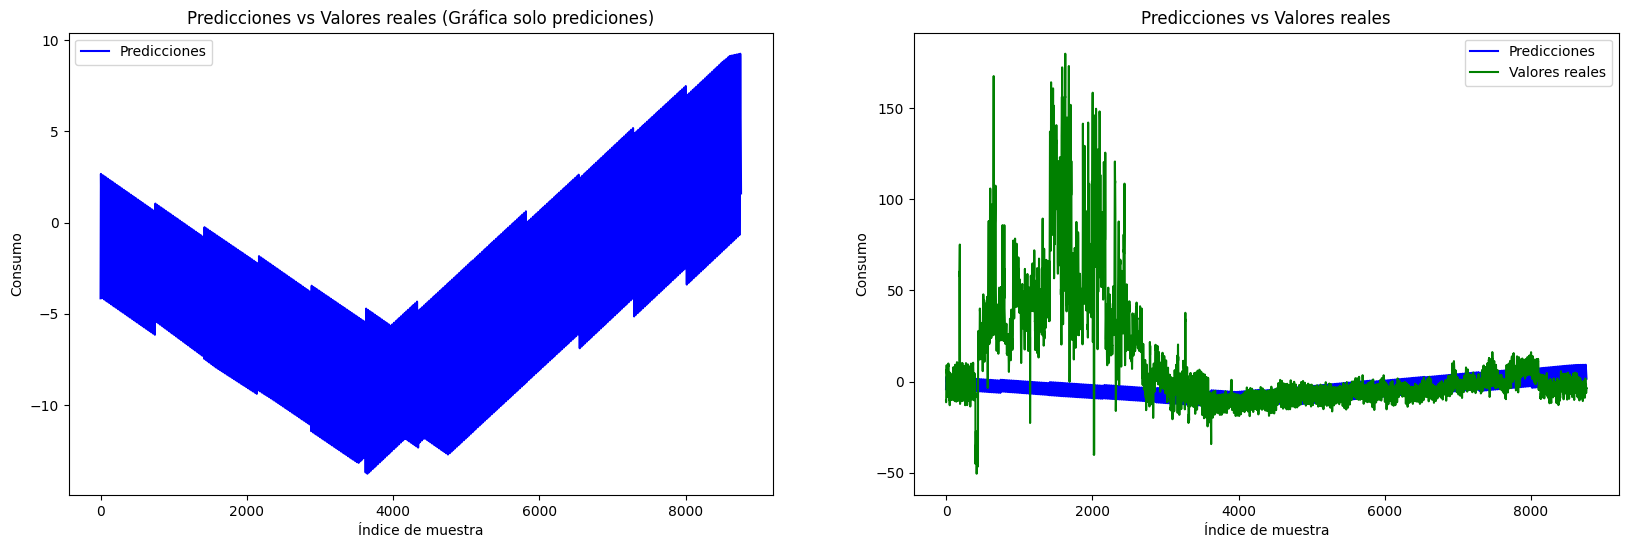

In [ ]:
predicciones = model.predict(X_test_mlp_FLORIDA)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_FLORIDA, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()

In [ ]:
tag="mlp_sn_LOSALME"+datetime.now().strftime("%Y%m%d-%H%M%S")

# Entrenar el modelo
history = model.fit(X_train_mlp_LOSALME, Y1_train_mlp_LOSALME, epochs=20, validation_data=(X_test_mlp_LOSALME, Y1_test_mlp_LOSALME), batch_size=batch_size)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_mlp_LOSALME, Y1_test_mlp_LOSALME)
print(f'\nTest loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test MAPE: {test_mape}')
model.save('models/model_{0}'.format(tag))

Epoch 1/20
546/546 [==============================] - 1s 1ms/step - loss: 37.3225 - mae: 37.3225 - mse: 2384.3267 - mape: 285107456.0000 - val_loss: 52.4727 - val_mae: 52.4727 - val_mse: 5875.7065 - val_mape: 22889204.0000
Epoch 2/20
546/546 [==============================] - 1s 2ms/step - loss: 31.9973 - mae: 31.9973 - mse: 1653.9401 - mape: 288050080.0000 - val_loss: 53.8996 - val_mae: 53.8996 - val_mse: 5975.4849 - val_mape: 23713914.0000
Epoch 3/20
546/546 [==============================] - 1s 2ms/step - loss: 30.7595 - mae: 30.7595 - mse: 1549.9291 - mape: 284193536.0000 - val_loss: 54.9434 - val_mae: 54.9434 - val_mse: 6279.4141 - val_mape: 23885856.0000
Epoch 4/20
546/546 [==============================] - 1s 2ms/step - loss: 29.4236 - mae: 29.4236 - mse: 1432.1943 - mape: 287401376.0000 - val_loss: 55.6110 - val_mae: 55.6110 - val_mse: 6319.8203 - val_mape: 24516880.0000
Epoch 5/20
546/546 [==============================] - 1s 2ms/step - loss: 28.4533 - mae: 28.4533 - mse: 1352

INFO:tensorflow:Assets written to: models/model_mlp_sn_LOSALME20240425-233332\assets


In [ ]:
predicciones = model.predict(X_test_mlp_LOSALME)
# Crear una figura
plt.figure(figsize=(20, 6))

# Primera gráfica
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(predicciones, label='Predicciones', color='blue')  # Asume que predicciones1 es para la primera gráfica
plt.title('Predicciones vs Valores reales (Gráfica solo prediciones)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Segunda gráfica
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(predicciones, label='Predicciones', color='blue')
plt.plot(Y1_test_mlp_LOSALME, label='Valores reales', color='green')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()

# Mostrar las gráficas
plt.show()


274/274 [==============================] - 0s 813us/step


In [ ]:
#separar datos de entrenamiento y validacion para arima
barras = dataset['barra'].unique() #Se puede usar el dataset de arima.

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación
train_arima_sn_dict = {}
test_train_arima_sn_dict = {}

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    df_train = pd.concat([df_train, df_test])

    df_train = df_train.set_index('horario')
    df_test = df_test.set_index('horario')

    # Divide los datos en entrenamiento y validación
    train_arima_sn_dict[barra] = df_train[['consumo']]
    test_train_arima_sn_dict[barra] = df_test[['consumo']]

In [ ]:
#separar datos de entrenamiento y validacion para arima
barras = dataset['barra'].unique()

# Crea diccionarios para almacenar los conjuntos de entrenamiento y validación
train_dict = {}
validation_dict = {}

for barra in barras:
    df_train = data_train[data_train['barra'] == barra]
    df_test = data_test[data_test['barra'] == barra]
    
    # Ordena el dataframe por la columna 'horario'
    df_train = df_train.sort_values('horario')
    df_test = df_test.sort_values('horario')

    # Divide los datos en entrenamiento y validación
    train_dict[barra] = df_train[['consumo']]
    validation_dict[barra] = df_test[['consumo']]

# ESTO SIRVE TAMBIEN PARA RNN

In [ ]:
for barra in dataset['barra'].unique():
    print("--------------------------------")
    print("BARRA",barra)
    statistic, p_value, n_lags, critical_values = kpss(train_dict[barra].values)
    print(f"Estadístico KPSS: {statistic}\nValor p: {p_value}\nValores críticos: {critical_values}")
    print("La serie es estacionaria.") if p_value < 0.05 else print("La serie no es estacionaria.")
    print("--------------------------------")

--------------------------------
BARRA AJAHUEL
Estadístico KPSS: 0.9794760789016098
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA BUIN
Estadístico KPSS: 0.8747997965945181
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA CHENA
Estadístico KPSS: 2.152343848551646
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA CNAVIA
Estadístico KPSS: 4.292372256555857
Valor p: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
La serie es estacionaria.
--------------------------------
--------------------------------
BARRA ELSALTO
Estadístico KPSS: 0.9528920240212954


C:\Users\tolli\AppData\Local\Temp\ipykernel_15696\1562785255.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_dict[barra].values)
C:\Users\tolli\AppData\Local\Temp\ipykernel_15696\1562785255.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_dict[barra].values)
C:\Users\tolli\AppData\Local\Temp\ipykernel_15696\1562785255.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(train_dict[barra].values)
C:\Users\tolli\AppData\Local\Temp\ipykernel_15696\1562785255.

### SERIES DE TIEMPO CON AJAHUEL

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['AJAHUEL'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_AJAHUEL_fit = model.fit()

# Hacer predicciones para 2023 con AJAHUEL.
prediccion_AJAHUEL = model_AJAHUEL_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['AJAHUEL']
y_pred = prediccion_AJAHUEL

if len(test_train_arima_sn_dict['AJAHUEL']) > len(prediccion_AJAHUEL):
    y_true = test_train_arima_sn_dict['AJAHUEL'][:len(prediccion_AJAHUEL)]
elif len(test_train_arima_sn_dict['AJAHUEL']) < len(prediccion_AJAHUEL):
    y_pred = prediccion_AJAHUEL[:len(test_train_arima_sn_dict['AJAHUEL'])]

print("MAE",model_AJAHUEL_fit.mae)
print("MSE",model_AJAHUEL_fit.mse)
print("AIC",model_AJAHUEL_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_AJAHUEL_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 8.297201255604781
MSE 206.70822250295922
AIC 356712.28298433626
mape 96357470595666.69


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -178353.141
Date:                Thu, 25 Apr 2024   AIC                         356712.283
Time:                        23:33:53   BIC                         356738.337
Sample:                             0   HQIC                        356720.496
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5296      0.003    189.429      0.000       0.524       0.535
ma.L1          0.0172      0.002      7.567      0.000       0.013       0.022
sigma2       206.2646      0.271    761.666      0.000     205.734     206.795
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          19443947.31
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       106.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Hacer predicciones para 2023 con AJAHUEL.
prediccion_AJAHUEL = model_AJAHUEL_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_AJAHUEL = prediccion_AJAHUEL[~prediccion_AJAHUEL.index.duplicated(keep='first')]
prediccion_AJAHUEL = prediccion_AJAHUEL.reindex(test_train_arima_sn_dict['AJAHUEL'].index)

plt.plot(test_train_arima_sn_dict['AJAHUEL'].index, test_train_arima_sn_dict['AJAHUEL']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['AJAHUEL'].index, prediccion_AJAHUEL, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra AJAHUEL) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['BUIN'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_BUIN_fit = model.fit()

# Hacer predicciones para 2023 con BUIN.
prediccion_BUIN = model_BUIN_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['BUIN']
y_pred = prediccion_BUIN

if len(test_train_arima_sn_dict['BUIN']) > len(prediccion_BUIN):
    y_true = test_train_arima_sn_dict['BUIN'][:len(prediccion_BUIN)]
elif len(test_train_arima_sn_dict['BUIN']) < len(prediccion_BUIN):
    y_pred = prediccion_BUIN[:len(test_train_arima_sn_dict['BUIN'])]

print("MAE",model_BUIN_fit.mae)
print("MSE",model_BUIN_fit.mse)
print("AIC",model_BUIN_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_BUIN_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 20.281763076291867
MSE 2690.13135331007
AIC 468862.83658613433
mape 139608346905054.22


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -234428.418
Date:                Thu, 25 Apr 2024   AIC                         468862.837
Time:                        23:34:06   BIC                         468888.890
Sample:                             0   HQIC                        468871.049
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3119      0.061      5.136      0.000       0.193       0.431
ma.L1         -0.2470      0.061     -4.027      0.000      -0.367      -0.127
sigma2      2689.1485      6.061    443.704      0.000    2677.270    2701.027
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):            496473.67
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

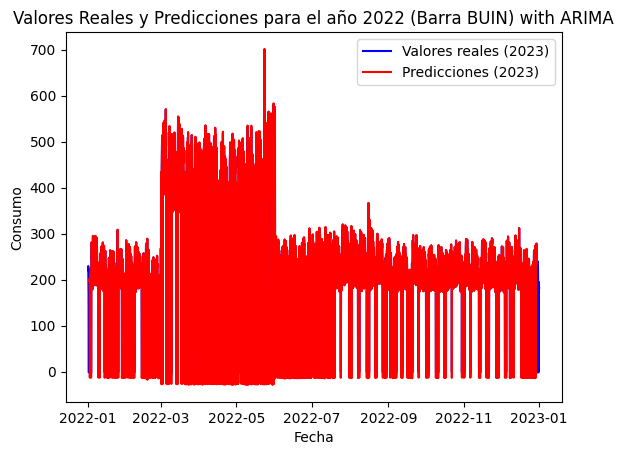

In [ ]:
# Hacer predicciones para 2023 con BUIN.
prediccion_BUIN = model_BUIN_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_BUIN = prediccion_BUIN[~prediccion_BUIN.index.duplicated(keep='first')]
prediccion_BUIN = prediccion_BUIN.reindex(test_train_arima_sn_dict['BUIN'].index)

plt.plot(test_train_arima_sn_dict['BUIN'].index, test_train_arima_sn_dict['BUIN']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['BUIN'].index, prediccion_BUIN, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra BUIN) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['CHENA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_CHENA_fit = model.fit()

# Hacer predicciones para 2023 con CHENA.
prediccion_CHENA = model_CHENA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['CHENA']
y_pred = prediccion_CHENA

if len(test_train_arima_sn_dict['CHENA']) > len(prediccion_CHENA):
    y_true = test_train_arima_sn_dict['CHENA'][:len(prediccion_CHENA)]
elif len(test_train_arima_sn_dict['CHENA']) < len(prediccion_CHENA):
    y_pred = prediccion_CHENA[:len(test_train_arima_sn_dict['CHENA'])]

print("MAE",model_CHENA_fit.mae)
print("MSE",model_CHENA_fit.mse)
print("AIC",model_CHENA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_CHENA_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 28.677905213181383
MSE 3082.606762608241
AIC 474776.63603023964
mape 290286534991142.44


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -237385.318
Date:                Thu, 25 Apr 2024   AIC                         474776.636
Time:                        23:34:18   BIC                         474802.690
Sample:                             0   HQIC                        474784.849
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4559      0.014     31.486      0.000       0.427       0.484
ma.L1         -0.2632      0.015    -17.741      0.000      -0.292      -0.234
sigma2      3075.8505      7.016    438.399      0.000    3062.099    3089.602
===================================================================================
Ljung-Box (L1) (Q):                   2.77   Jarque-Bera (JB):            603068.59
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Hacer predicciones para 2023 con CHENA.
prediccion_CHENA = model_CHENA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_CHENA = prediccion_CHENA[~prediccion_CHENA.index.duplicated(keep='first')]
prediccion_CHENA = prediccion_CHENA.reindex(test_train_arima_sn_dict['CHENA'].index)

plt.plot(test_train_arima_sn_dict['CHENA'].index, test_train_arima_sn_dict['CHENA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['CHENA'].index, prediccion_CHENA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra CHENA) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['CNAVIA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_CNAVIA_fit = model.fit()

# Hacer predicciones para 2023 con CNAVIA.
prediccion_CNAVIA = model_CNAVIA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['CNAVIA']
y_pred = prediccion_CNAVIA

if len(test_train_arima_sn_dict['CNAVIA']) > len(prediccion_CNAVIA):
    y_true = test_train_arima_sn_dict['CNAVIA'][:len(prediccion_CNAVIA)]
elif len(test_train_arima_sn_dict['CNAVIA']) < len(prediccion_CNAVIA):
    y_pred = prediccion_CNAVIA[:len(test_train_arima_sn_dict['CNAVIA'])]

print("MAE",model_CNAVIA_fit.mae)
print("MSE",model_CNAVIA_fit.mse)
print("AIC",model_CNAVIA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_CNAVIA_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 20.754829447741425
MSE 1271.623770474885
AIC 436058.5589394837
mape 0.07403565174752076


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -218026.279
Date:                Thu, 25 Apr 2024   AIC                         436058.559
Time:                        23:34:29   BIC                         436084.613
Sample:                             0   HQIC                        436066.772
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5242      0.006     90.952      0.000       0.513       0.535
ma.L1         -0.1913      0.006    -34.721      0.000      -0.202      -0.180
sigma2      1268.5914      1.920    660.756      0.000    1264.828    1272.354
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):           5546041.53
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Hacer predicciones para 2023 con CNAVIA.
prediccion_CNAVIA = model_CNAVIA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_CNAVIA = prediccion_CNAVIA[~prediccion_CNAVIA.index.duplicated(keep='first')]
prediccion_CNAVIA = prediccion_CNAVIA.reindex(test_train_arima_sn_dict['CNAVIA'].index)

plt.plot(test_train_arima_sn_dict['CNAVIA'].index, test_train_arima_sn_dict['CNAVIA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['CNAVIA'].index, prediccion_CNAVIA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra CNAVIA) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['ELSALTO'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_ELSALTO_fit = model.fit()

# Hacer predicciones para 2023 con ELSALTO.
prediccion_ELSALTO = model_ELSALTO_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['ELSALTO']
y_pred = prediccion_ELSALTO

if len(test_train_arima_sn_dict['ELSALTO']) > len(prediccion_ELSALTO):
    y_true = test_train_arima_sn_dict['ELSALTO'][:len(prediccion_ELSALTO)]
elif len(test_train_arima_sn_dict['ELSALTO']) < len(prediccion_ELSALTO):
    y_pred = prediccion_ELSALTO[:len(test_train_arima_sn_dict['ELSALTO'])]

print("MAE",model_ELSALTO_fit.mae)
print("MSE",model_ELSALTO_fit.mse)
print("AIC",model_ELSALTO_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_ELSALTO_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 20.876823846181058
MSE 1378.5956163559124
AIC 439645.13883211475
mape 292435067352752.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -219819.569
Date:                Thu, 25 Apr 2024   AIC                         439645.139
Time:                        23:34:41   BIC                         439671.192
Sample:                             0   HQIC                        439653.352
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5834      0.007     81.438      0.000       0.569       0.597
ma.L1         -0.2828      0.007    -40.077      0.000      -0.297      -0.269
sigma2      1376.1304      1.872    735.123      0.000    1372.461    1379.799
===================================================================================
Ljung-Box (L1) (Q):                   4.20   Jarque-Bera (JB):           7588057.31
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Hacer predicciones para 2023 con ELSALTO.
prediccion_ELSALTO = model_ELSALTO_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_ELSALTO = prediccion_ELSALTO[~prediccion_ELSALTO.index.duplicated(keep='first')]
prediccion_ELSALTO = prediccion_ELSALTO.reindex(test_train_arima_sn_dict['ELSALTO'].index)

plt.plot(test_train_arima_sn_dict['ELSALTO'].index, test_train_arima_sn_dict['ELSALTO']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['ELSALTO'].index, prediccion_ELSALTO, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra ELSALTO) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['FLORIDA'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_FLORIDA_fit = model.fit()

# Hacer predicciones para 2023 con FLORIDA.
prediccion_FLORIDA = model_FLORIDA_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['FLORIDA']
y_pred = prediccion_FLORIDA

if len(test_train_arima_sn_dict['FLORIDA']) > len(prediccion_FLORIDA):
    y_true = test_train_arima_sn_dict['FLORIDA'][:len(prediccion_FLORIDA)]
elif len(test_train_arima_sn_dict['FLORIDA']) < len(prediccion_FLORIDA):
    y_pred = prediccion_FLORIDA[:len(test_train_arima_sn_dict['FLORIDA'])]

print("MAE",model_FLORIDA_fit.mae)
print("MSE",model_FLORIDA_fit.mse)
print("AIC",model_FLORIDA_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_FLORIDA_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 1.6953630055791638
MSE 22.012023812044585
AIC 258982.35080836833
mape 1.1241991359321346


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -129488.175
Date:                Thu, 25 Apr 2024   AIC                         258982.351
Time:                        23:34:53   BIC                         259008.404
Sample:                             0   HQIC                        258990.564
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3739      0.015    -24.843      0.000      -0.403      -0.344
ma.L1          0.4283      0.015     29.269      0.000       0.400       0.457
sigma2        22.0116      0.017   1292.321      0.000      21.978      22.045
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):          45537301.61
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                       161.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

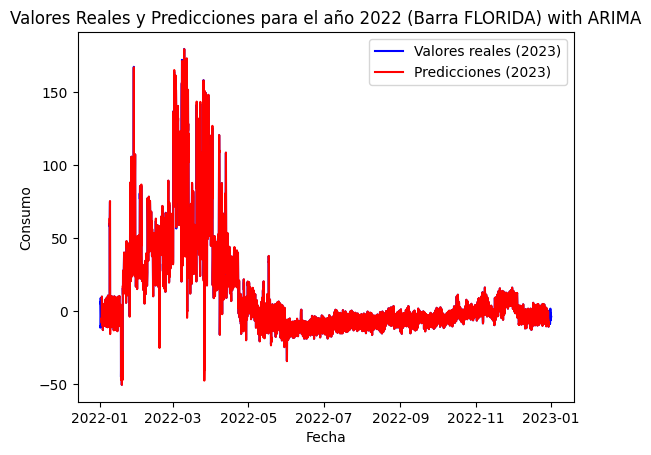

In [ ]:
# Hacer predicciones para 2023 con FLORIDA.
prediccion_FLORIDA = model_FLORIDA_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_FLORIDA = prediccion_FLORIDA[~prediccion_FLORIDA.index.duplicated(keep='first')]
prediccion_FLORIDA = prediccion_FLORIDA.reindex(test_train_arima_sn_dict['FLORIDA'].index)

plt.plot(test_train_arima_sn_dict['FLORIDA'].index, test_train_arima_sn_dict['FLORIDA']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['FLORIDA'].index, prediccion_FLORIDA, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra FLORIDA) with ARIMA')
plt.legend()

In [ ]:
# Entrenar el modelo ARIMA
model = ARIMA(train_arima_sn_dict['LOSALME'], order=(1, 1, 1)) #Creo que 1,1,1 es más conveniente.
model_LOSALME_fit = model.fit()

# Hacer predicciones para 2023 con LOSALME.
prediccion_LOSALME = model_LOSALME_fit.predict(start ='2022-01-01', end='2022-12-31')

y_true = test_train_arima_sn_dict['LOSALME']
y_pred = prediccion_LOSALME

if len(test_train_arima_sn_dict['LOSALME']) > len(prediccion_LOSALME):
    y_true = test_train_arima_sn_dict['LOSALME'][:len(prediccion_LOSALME)]
elif len(test_train_arima_sn_dict['LOSALME']) < len(prediccion_LOSALME):
    y_pred = prediccion_LOSALME[:len(test_train_arima_sn_dict['LOSALME'])]

print("MAE",model_LOSALME_fit.mae)
print("MSE",model_LOSALME_fit.mse)
print("AIC",model_LOSALME_fit.aic)
print("mape",mean_absolute_percentage_error(y_true, y_pred))
model_LOSALME_fit.summary()

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE 8.264317675812723
MSE 205.0145630240507
AIC 356201.3821182895
mape 102773220241298.75


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                consumo   No. Observations:                43677
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -178097.691
Date:                Thu, 25 Apr 2024   AIC                         356201.382
Time:                        23:35:05   BIC                         356227.436
Sample:                             0   HQIC                        356209.595
                              - 43677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5276      0.004    121.401      0.000       0.519       0.536
ma.L1         -0.0975      0.004    -25.036      0.000      -0.105      -0.090
sigma2       203.8640      0.270    755.347      0.000     203.335     204.393
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):          22049415.72
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Hacer predicciones para 2023 con LOSALME.
prediccion_LOSALME = model_LOSALME_fit.predict(start ='2022-01-02', end='2022-12-30') 
prediccion_LOSALME = prediccion_LOSALME[~prediccion_LOSALME.index.duplicated(keep='first')]
prediccion_LOSALME = prediccion_LOSALME.reindex(test_train_arima_sn_dict['LOSALME'].index)

plt.plot(test_train_arima_sn_dict['LOSALME'].index, test_train_arima_sn_dict['LOSALME']['consumo'], label='Valores reales (2022)', color='blue')
plt.plot(test_train_arima_sn_dict['LOSALME'].index, prediccion_LOSALME, label='Predicciones (2022)', color='red')

plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Valores Reales y Predicciones para el año 2022 (Barra LOSALME) with ARIMA')
plt.legend()

In [ ]:
#separar datos de entrenamiento y validacion para rnn
# Crea diccionarios para almacenar los resultados
yw_train_dict = {}#X step entrada
yt_train_dict = {}#Y train salida
yw_validation_dict = {}#X step entrada
yt_validation_dict = {}#Y test salida

window_size = 40

# Itera sobre train_dict
for barra, df in train_dict.items():
    y = df['consumo'].values
    yw = []
    yt = []
    for i in range(0, len(y)):
        if i + window_size < len(y):
            row = []
            for j in range(window_size):
                row.append(y[i+j])
            yw.append(row)
            yt.append(y[i+window_size])
        else:
            break
    yw_train_dict[barra] = np.array(yw).astype('float32')
    yt_train_dict[barra] = np.array(yt).astype('float32')

# Itera sobre validation_dict
for barra, df in validation_dict.items():
    y = df['consumo'].values
    yw = []
    yt = []
    for i in range(0, len(y)):
        if i + window_size < len(y):
            row = []
            for j in range(window_size):
                row.append(y[i+j])
            yw.append(row)
            yt.append(y[i+window_size])
        else:
            break
    yw_validation_dict[barra] = np.array(yw).astype('float32')
    yt_validation_dict[barra] = np.array(yt).astype('float32')


In [ ]:
model = Sequential([
    Input(name="serie", shape=(window_size, 1)),
    SimpleRNN(window_size),
    Dense(1, activation='linear')
])

model.compile(optimizer='Adam', loss='mse', metrics=['mse','mae','mape'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 40)                1680      
                                                                 
 dense_19 (Dense)            (None, 1)                 41        
                                                                 
Total params: 1721 (6.72 KB)
Trainable params: 1721 (6.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tag = "rnn_se_sn_AJAHUEL" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['AJAHUEL'],
    yt_train_dict['AJAHUEL'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['AJAHUEL'],yt_validation_dict['AJAHUEL']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36


1163/1163 [==============================] - 9s 6ms/step - loss: 20542.0957 - mse: 20542.0957 - mae: 132.4784 - mape: 15139868.0000 - val_loss: 32570.1367 - val_mse: 32570.1367 - val_mae: 154.7213 - val_mape: 10802144.0000
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 11292.5518 - mse: 11292.5518 - mae: 92.4919 - mape: 38081436.0000 - val_loss: 22190.7148 - val_mse: 22190.7148 - val_mae: 119.3018 - val_mape: 17895962.0000
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 5931.4824 - mse: 5931.4824 - mae: 61.1902 - mape: 45932844.0000 - val_loss: 15411.2217 - val_mse: 15411.2217 - val_mae: 91.1980 - val_mape: 21540618.0000
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 3023.1772 - mse: 3023.1772 - mae: 39.0453 - mape: 57940316.0000 - val_loss: 10987.0645 - val_mse: 10987.0635 - val_mae: 70.1357 - val_mape: 21996456.0000
Epoch 5/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1527.804

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


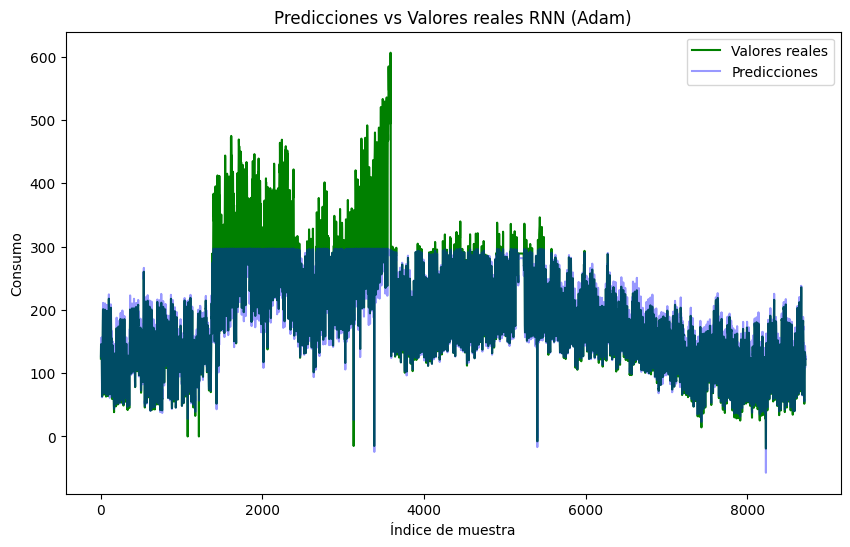

In [ ]:
predicciones = model.predict(yw_validation_dict['AJAHUEL'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['AJAHUEL'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = "mape",mean_absolute_percentage_error(yt_validation_dict['AJAHUEL'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 93162110000000.0
Final MAE:  17.461612701416016
Final MSE:  1447.413818359375
Final mape:  None


In [ ]:
tag = "rnn_se_sn_BUIN" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['BUIN'],
    yt_train_dict['BUIN'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['BUIN'],yt_validation_dict['BUIN']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1775.9175 - mse: 1775.9175 - mae: 23.3482 - mape: 252233360.0000 - val_loss: 7677.6816 - val_mse: 7677.6816 - val_mae: 49.3712 - val_mape: 29934462.0000
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1693.1964 - mse: 1693.1964 - mae: 22.6387 - mape: 253134912.0000 - val_loss: 7698.7256 - val_mse: 7698.7256 - val_mae: 48.3117 - val_mape: 30219108.0000
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1648.1702 - mse: 1648.1702 - mae: 22.0366 - mape: 252364528.0000 - val_loss: 7624.5928 - val_mse: 7624.5928 - val_mae: 48.3899 - val_mape: 30285750.0000
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1630.7523 - mse: 1630.7523 - mae: 22.0318 - mape: 247542288.0000 - val_loss: 7483.3374 - val_mse: 7483.3374 - val_mae: 48.0849 - val_mape: 30353388.0000
Epoch 5/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1622.174

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['BUIN'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['BUIN'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

110/273 [===========>..................] - ETA: 0s

273/273 [==============================] - 1s 3ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['BUIN'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 134568700000000.0
Final MAE:  45.00102996826172
Final MSE:  7027.68017578125
Final mape:  None


In [ ]:
tag = "rnn_se_sn_CHENA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['CHENA'],
    yt_train_dict['CHENA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['CHENA'],yt_validation_dict['CHENA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 8s 7ms/step - loss: 10370.4668 - mse: 10370.4668 - mae: 77.3392 - mape: 413216384.0000 - val_loss: 71309.5625 - val_mse: 71309.5625 - val_mae: 168.5810 - val_mape: 46471148.0000
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 5576.3911 - mse: 5576.3911 - mae: 53.1365 - mape: 461401504.0000 - val_loss: 58919.2422 - val_mse: 58919.2422 - val_mae: 145.5664 - val_mape: 50481860.0000
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 3746.4282 - mse: 3746.4282 - mae: 41.7140 - mape: 486134848.0000 - val_loss: 52188.4141 - val_mse: 52188.4141 - val_mae: 133.1582 - val_mape: 53677092.0000
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 2815.7231 - mse: 2815.7231 - mae: 34.6011 - mape: 497898848.0000 - val_loss: 47291.5703 - val_mse: 47291.5703 - val_mae: 122.9393 - val_mape: 56296284.0000
Epoch 5/36
1163/1163 [==============================] - 7s 6ms/step - 

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


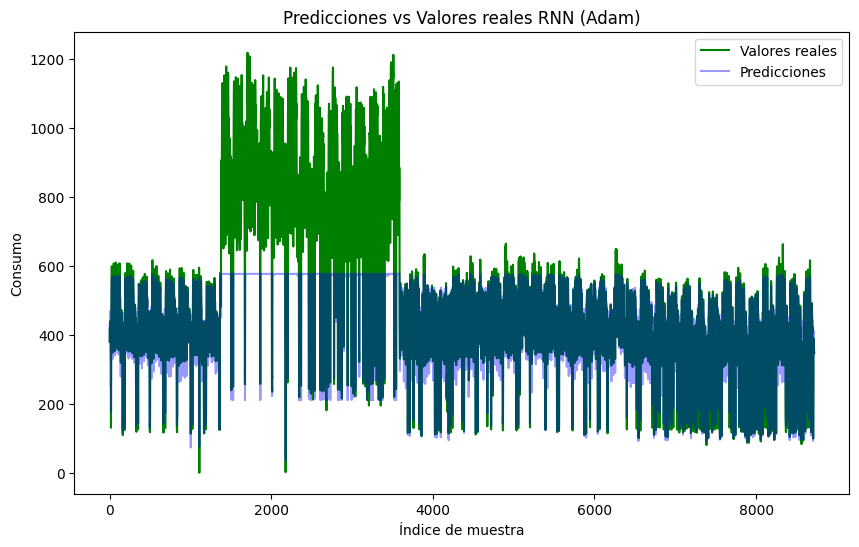

In [ ]:
predicciones = model.predict(yw_validation_dict['CHENA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['CHENA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['CHENA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 277633000000000.0
Final MAE:  97.60198211669922
Final MSE:  32242.763671875
Final mape:  None


In [ ]:
tag = "rnn_se_sn_CNAVIA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['CNAVIA'],
    yt_train_dict['CNAVIA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['CNAVIA'],yt_validation_dict['CNAVIA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 999.4805 - mse: 999.4805 - mae: 20.7151 - mape: 66479844.0000 - val_loss: 35901.1055 - val_mse: 35901.1055 - val_mae: 94.3388 - val_mape: 14.1447
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 929.2700 - mse: 929.2700 - mae: 19.5545 - mape: 66309408.0000 - val_loss: 35358.8242 - val_mse: 35358.8242 - val_mae: 93.3223 - val_mape: 14.0222
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 905.7967 - mse: 905.7967 - mae: 19.2297 - mape: 67602744.0000 - val_loss: 34737.3789 - val_mse: 34737.3789 - val_mae: 92.7439 - val_mape: 14.1319
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 900.0313 - mse: 900.0313 - mae: 19.2798 - mape: 67916272.0000 - val_loss: 31556.8223 - val_mse: 31556.8223 - val_mae: 87.4893 - val_mape: 13.4530
Epoch 5/36
1163/1163 [==============================] - 7s 6ms/step - loss: 896.5289 - mse: 896.5289 - mae: 19.2

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['CNAVIA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['CNAVIA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

273/273 [==============================] - 1s 2ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['CNAVIA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 0.13651203
Final MAE:  88.85162353515625
Final MSE:  30633.515625
Final mape:  None


In [ ]:
tag = "rnn_se_sn_ELSALTO" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['ELSALTO'],
    yt_train_dict['ELSALTO'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['ELSALTO'],yt_validation_dict['ELSALTO']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 6s 5ms/step - loss: 1100.4919 - mse: 1100.4919 - mae: 19.7325 - mape: 757544128.0000 - val_loss: 27513.0371 - val_mse: 27513.0371 - val_mae: 84.5423 - val_mape: 61518520.0000
Epoch 2/36
1163/1163 [==============================] - 6s 5ms/step - loss: 1058.3098 - mse: 1058.3098 - mae: 19.1967 - mape: 689456064.0000 - val_loss: 27219.2559 - val_mse: 27219.2539 - val_mae: 82.8140 - val_mape: 63865388.0000
Epoch 3/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1044.3922 - mse: 1044.3922 - mae: 18.8826 - mape: 674740992.0000 - val_loss: 27084.8145 - val_mse: 27084.8145 - val_mae: 82.6637 - val_mape: 63520288.0000
Epoch 4/36
1163/1163 [==============================] - 7s 6ms/step - loss: 1034.8156 - mse: 1034.8156 - mae: 18.8748 - mape: 667335232.0000 - val_loss: 26991.4648 - val_mse: 26991.4648 - val_mae: 83.2610 - val_mape: 63005888.0000
Epoch 5/36
1163/1163 [==============================] - 7s 6ms/step - loss: 

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 1s 2ms/step


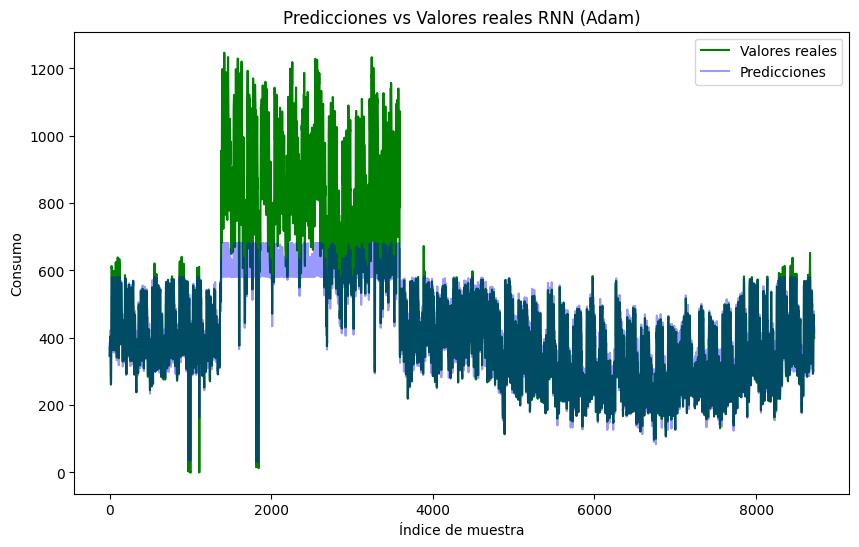

In [ ]:
predicciones = model.predict(yw_validation_dict['ELSALTO'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['ELSALTO'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['ELSALTO'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 293063640000000.0
Final MAE:  77.2448501586914
Final MSE:  21839.796875
Final mape:  None


In [ ]:
tag = "rnn_se_sn_FLORIDA" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['FLORIDA'],
    yt_train_dict['FLORIDA'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['FLORIDA'],yt_validation_dict['FLORIDA']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 7s 6ms/step - loss: 93.0602 - mse: 93.0602 - mae: 5.8225 - mape: 2720896.2500 - val_loss: 81.5700 - val_mse: 81.5700 - val_mae: 5.0132 - val_mape: 529.5967
Epoch 2/36
1163/1163 [==============================] - 7s 6ms/step - loss: 35.9634 - mse: 35.9634 - mae: 2.9552 - mape: 2642552.2500 - val_loss: 73.4721 - val_mse: 73.4721 - val_mae: 4.2243 - val_mape: 526.1743
Epoch 3/36
1163/1163 [==============================] - 6s 5ms/step - loss: 31.4300 - mse: 31.4300 - mae: 2.4557 - mape: 2658258.5000 - val_loss: 68.6377 - val_mse: 68.6377 - val_mae: 3.8241 - val_mape: 471.9037
Epoch 4/36
1163/1163 [==============================] - 6s 5ms/step - loss: 27.9406 - mse: 27.9406 - mae: 2.2455 - mape: 2700182.7500 - val_loss: 67.4334 - val_mse: 67.4334 - val_mae: 3.7183 - val_mape: 464.6243
Epoch 5/36
1163/1163 [==============================] - 6s 5ms/step - loss: 26.1463 - mse: 26.1463 - mae: 2.1793 - mape: 2733325.7500 - val_loss: 69.381

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 0s 2ms/step


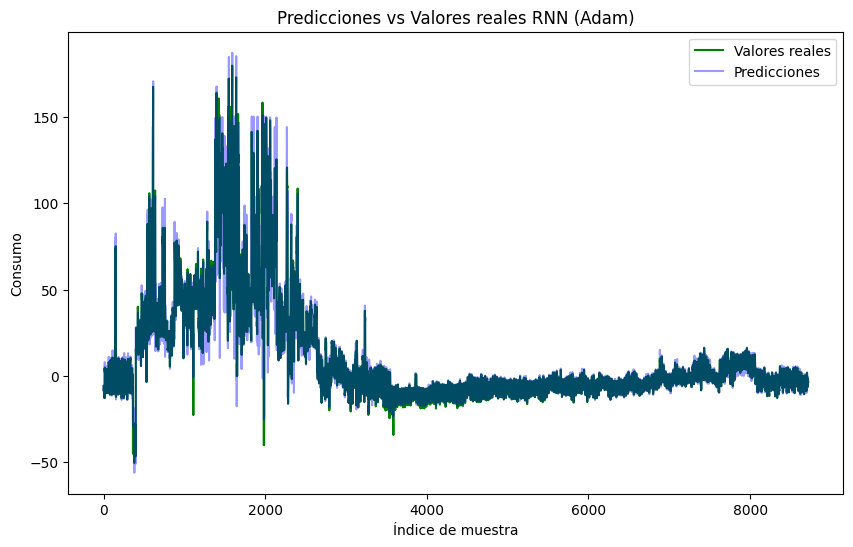

In [ ]:
predicciones = model.predict(yw_validation_dict['FLORIDA'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['FLORIDA'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['FLORIDA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

mape 1.157929
Final MAE:  3.005073308944702
Final MSE:  54.2440299987793
Final mape:  None


In [ ]:
tag = "rnn_se_sn_LOSALME" + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs_sn/fit/" + tag

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


spam_rnn = model.fit(
    yw_train_dict['LOSALME'],
    yt_train_dict['LOSALME'],
    batch_size=30,
    epochs=36,
    validation_data=(yw_validation_dict['LOSALME'],yt_validation_dict['LOSALME']),
    callbacks=[tensorboard_callback]
)
model.save('models/model_{0}.h5'.format(tag))

Epoch 1/36
1163/1163 [==============================] - 6s 5ms/step - loss: 201.8029 - mse: 201.8029 - mae: 9.3362 - mape: 153175712.0000 - val_loss: 415.0602 - val_mse: 415.0602 - val_mae: 12.0405 - val_mape: 23158708.0000
Epoch 2/36
1163/1163 [==============================] - 6s 5ms/step - loss: 177.4267 - mse: 177.4267 - mae: 8.5789 - mape: 155933024.0000 - val_loss: 952.9830 - val_mse: 952.9830 - val_mae: 16.3309 - val_mape: 22752258.0000
Epoch 3/36
1163/1163 [==============================] - 5s 5ms/step - loss: 168.9370 - mse: 168.9370 - mae: 8.3808 - mape: 167082304.0000 - val_loss: 908.0044 - val_mse: 908.0044 - val_mae: 15.9301 - val_mape: 23378004.0000
Epoch 4/36
1163/1163 [==============================] - 6s 5ms/step - loss: 163.9612 - mse: 163.9612 - mae: 8.1666 - mape: 169138672.0000 - val_loss: 857.9235 - val_mse: 857.9235 - val_mae: 15.2574 - val_mape: 22848010.0000
Epoch 5/36
1163/1163 [==============================] - 5s 4ms/step - loss: 161.6582 - mse: 161.6582 - m

c:\Users\tolli\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predicciones = model.predict(yw_validation_dict['LOSALME'])


predicciones = np.reshape(predicciones, (predicciones.shape[0],))
# Grafica las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(yt_validation_dict['LOSALME'], label='Valores reales', color='green')
plt.plot(predicciones, label='Predicciones', color='blue', alpha = 0.4)
plt.title('Predicciones vs Valores reales RNN (Adam)')
plt.xlabel('Índice de muestra')
plt.ylabel('Consumo')
plt.legend()
plt.show()

273/273 [==============================] - 0s 1ms/step


In [ ]:
# Obtener el último valor de MAE y MSE
final_mae = spam_rnn.history['val_mae'][-1]
final_mse = spam_rnn.history['val_mse'][-1]
final_mape = mean_absolute_percentage_error(yt_validation_dict['FLORIDA'], predicciones)

print("Final MAE: ", final_mae)
print("Final MSE: ", final_mse)
print("Final mape: ", final_mape)

In [ ]:
mse_mlp = 1106.525
mse_arima = 22.012
mse_rnn = 54.244

mae_mlp = 17.517
mae_arima = 1.695
mae_rnn = 3.005

mape_mlp = 255.696
mape_arima = 1.124
mape_rnn = 1.158

modelos = ['MLP','ARIMA','RNN']

MSE_VALORES = [mse_mlp,mse_arima,mse_rnn]
MAE_VALORES = [mae_mlp,mae_arima,mae_rnn]
MAPE_VALORES = [mape_mlp,mape_arima,mape_rnn]

# GRAFICO COMPARACION MSE:

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MSE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MSE')
plt.ylabel('MSE')
plt.title('Comparacion rendimiento modelos usando MSE')
plt.ylim(0,max(MSE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MSE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MAE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MAE')
plt.ylabel('MAE')
plt.title('Comparacion rendimiento modelos usando MAE')
plt.ylim(0,max(MAE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MAE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()



In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, MAPE_VALORES, color=['blue','green','red'])
plt.xlabel('modelos with MAPE')
plt.ylabel('MAE')
plt.title('Comparacion rendimiento modelos usando MAPE')
plt.ylim(0,max(MAPE_VALORES) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas de texto a cada barra
for bar, valor in zip(bars, MAPE_VALORES):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(valor, 2),
             ha='center', va='bottom')
plt.show()